# Automation Version 4.2

Created 10/13/2019

Notebooks were divided for loading convenience into:

**Automation 4.1 (creating dictionaries)**
* creates all the dictionaries needed for analysis and saves them as csv files 
* do not need to run this notebook unless making edits to dictionaries

**Automation 4.2 (analysis)**
* Weighted Distance Analysis by Rachel Raikar and Antara Bhattacharya 
    * Analysis of comet plot:(score to unmodified Carbon template vs score to unmodified Weak CN template)
    * Distance from arbitrary points on this plot were used to weight the stars on CMDs for analysis
    * Please refer to Automation 2.7 for more information about the template methods and plots
    
 **Please refer to the [Methods](Methods_of_Analysis.txt) for description of methods of spectral analysis and  [DictionaryNames](DictionaryNames.txt) for names of dictionaries in each method.**
        

In [1]:
#tools needed for data analysis throughout the code
import os 
import numpy as np
import random
import array as arr
import math as m
import statistics as st
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import path
import seaborn as sns #used for plotting kernel density plots
import pandas as pd #used for turning data into dataframes(tables)
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel 
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import pdb
%matplotlib inline 

In [2]:
#comment out if not working!
from tqdm import tqdm_notebook as tqdm

In [3]:
#this is a universal pathname(using command line prompts). you do not have to change anything
# just have the WeakCN2019 folder within the SIP folder
#the datasets should be in the SIP folder not WeakCN
#the notebooks and validindices are in WeakCN

#reads the data from the SPLASH fits file
hdu = fits.open('../subMasterSPLASH2.fits')
#for the SPLASH survey, all data is contained in a single hdu entry, so the variable data contains all the data
data = (hdu[1].data)
#reads the data from the keckPHAT fits file
hdu2 = fits.open('../keckphat_catalog_replaced.fits')
#for the keckPHAT survey, all data is contained in a single hdu entry, so the variable data contains all the data
keckPHATdata = (hdu2[1].data)

In [4]:
#filters stars based on their ZQUAL scores and keeps only those where ZQUAL = 1, 3, or 4
#produces a list of the SPLASH indices of "valid" stars (those who meet the ZQUAL condition above)
#also produces a list of "invalid" star indices (those who have a ZQUAL that is not 1, 3, or 4)
validZQUAL = [1, 3, 4]
invalidStars = []
validStars = []

for star in range(data.size):
    if data["ZQUAL"][star] in validZQUAL:
        validStars.append(star)
    else:
        invalidStars.append(star)
        
#converts the lists into arrays for easier manipulation later on if needed
allinvalidstars = np.array(invalidStars)
allvalidstars = np.array(validStars)

In [5]:
#creates arrays that contain the indices of stars visually identified to be in the categories listed
#note that these indices only include stars that were found to be "valid" in the previous step
others = np.load('./validindices/nonCarbonOrCNIndices.npy') #other stars (normal stars)
allcarbon = np.load('./validindices/allCarbonIndices.npy') #all carbon stars (not CN)
wNm = np.load('./validindices/weakCNIndices.npy') #weak and marginal CN stars
extremes = np.load('./validindices/extremeCarbonIndices.npy') #different individual subsets of carbon stars (extremes, strongs, and mediums together make up allcarbon above)
strongs = np.load('./validindices/strongCarbonIndices.npy')
mediums = np.load('./validindices/mediumCarbonIndices.npy')
weaks = np.load('./validindices/weakCarbonIndices.npy') #stars suspected to be CN (weaks and marginals together make up wNm above)
marginals = np.load('./validindices/marginalCarbonIndices.npy')
#creates an array that accomodates for all of the other star indices in SPLASH that were not visually identified/sorted
outsiders_list = [i for i in range(data.size) if i not in others and i not in wNm and i not in allcarbon and i not in invalidStars]
outsiders = np.array(outsiders_list)
#creates sets of different types of stars that can later be used to more quickly test for membership
allcarbon_set, wNm_set, others_set = set(), set(), set()
allcarbon_set.update(allcarbon); wNm_set.update(wNm); others_set.update(others)

In [6]:
#after visual inspection, we decided to reclassify the following stars on 8/2/2019
#document of analysis can be found in AST-09 folder 2019 -'Smoothed Visual Star Inspection Results'

wNm = np.delete(wNm, np.where(wNm == 23058))
allcarbon = np.delete(allcarbon, np.where(allcarbon == 24013))
allcarbon = np.delete(allcarbon, np.where(allcarbon == 20492))
allcarbon = np.delete(allcarbon, np.where(allcarbon == 22283))
allcarbon = np.delete(allcarbon, np.where(allcarbon == 20558))
allcarbon = np.delete(allcarbon, np.where(allcarbon == 20867))
allcarbon = np.delete(allcarbon, np.where(allcarbon == 20083))
#append to their new classified group
others = np.append(others,23058)
wNm = np.append(wNm,[24013,20492,20558,20083])
print(len(wNm)) #previously 158 -now 161
print(len(allcarbon)) #previously 98 stars - now 92

161
92


In [7]:
#Raja thinks these stars were flagged on the basis of Raja's more careful inspection of zspec notes 
#Confirm with Alex and Arya
flaggedStars = {"allcarbon":[19905], "weaks":[21466], "marginals":[22159, 23248, 24545], "outsiders":[23368, 23390]}
flaggedStars_list = [19905, 21466, 22159, 23248, 23368, 23390, 24545]

In [8]:
#creates a new sample of other/normal stars that is based only on those that have PHAT data
#also creates a new sample of stars containing all of the "other" stars that have no PHAT data
photoOthers, nonphotoOthers, allPhotoStars = [], [], []
allPhotoStars_set, photoOthers_set = set(), set() #sets created for easier membership testing

filter336, filter475, filter814, filter110, filter160 = data["F336W"].tolist(), data["F475W"].tolist(), data["F814W"].tolist(), data["F110W"].tolist(), data["F160W"].tolist()
for star in allvalidstars:
    #checks for PHAT data: checking for data in the following filters
    identifiedFlag = False #a flag that checks whether the current star is an identified one, used later in creation of nonphotoOthers list
    if (not np.isnan(filter336[star]) and filter336[star] < 99) or (not np.isnan(filter475[star]) and filter475[star] < 99) or (not np.isnan(filter814[star]) and filter814[star] < 99) or (not np.isnan(filter110[star]) and filter110[star] < 99) or (not np.isnan(filter160[star]) and filter160[star] < 99):
        if star in others_set or star in wNm_set or star in allcarbon_set:
            allPhotoStars.append(star)
        if star in others_set:
            photoOthers.append(star)
            identifiedFlag = True
    if star in others_set and not identifiedFlag: #if this star is in "others" but was not just added to the photoOthers list
        nonphotoOthers.append(star)
        
allPhotoStars_set.update(allPhotoStars)
photoOthers_set.update(photoOthers)
print("Total number of weakCN,carbon,and other stars with photometric data:", len(allPhotoStars_set))
print("Individual counts (wNm and allcarbon not limited by photometry, photoOthers limited):", len(wNm_set), len(allcarbon_set), len(photoOthers_set))

Total number of weakCN,carbon,and other stars with photometric data: 8011
Individual counts (wNm and allcarbon not limited by photometry, photoOthers limited): 158 98 7760


In [9]:
#defining a list that consists of bright stars from the photoOthers list
bright = [i for i in photoOthers if data['F814W'][i] < 22 and data['F475W'][i] < 24]
print(len(bright))

2858


In [10]:
#creates (mask,slit,objID):index dictionaries to speed up process of finding keckPHAT data for each star
keckIndex_dict = {}
for i in range(len(keckPHATdata['KOBJNAME'])):
    #first pad KSLITNAME with as many 0s as required
    slitName = keckPHATdata['KSLITNAME'][i]
    slitName = '0'*(3-len(str(slitName))) + str(slitName)
    keckIndex_dict[(keckPHATdata['KMASK'][i], slitName, keckPHATdata['KOBJNAME'][i])] = i

In [11]:
#creates the new photoOthers sample based on data from the keckPHAT catalog
keckPhotoOthers, nonKeckPhotoOthers = [], []
keckPhotoOthers_set, indSet = set(), set()
ctr = 0
for star in photoOthers:
    keckInd = keckIndex_dict[(data['MASK'][star], data['SLITNAME'][star], data['OBJNAME'][star])]
    if keckInd in indSet:
        print(str(keckInd) + ': duplicate')
    indSet.add(keckInd)
    if keckPHATdata['BRIGHTFLAG'][keckInd] == 0 and keckPHATdata['CONTFRAC'][keckInd] < 0.5:
        keckPhotoOthers.append(star)
    else:
        nonKeckPhotoOthers.append(star)
    ctr += 1
    if ctr % 500 == 0:
        print(str(ctr) + " stars completed.") 

keckPhotoOthers_set.update(keckPhotoOthers)
print(str(len(photoOthers)) + ' stars in photoOthers became ' + str(len(keckPhotoOthers)) + ' stars in keckPhotoOthers.')

500 stars completed.
1000 stars completed.
1500 stars completed.
2000 stars completed.
2500 stars completed.
3000 stars completed.
3500 stars completed.
4000 stars completed.
4500 stars completed.
5000 stars completed.
5500 stars completed.
6000 stars completed.
6500 stars completed.
7000 stars completed.
7500 stars completed.
7760 stars in photoOthers became 5586 stars in keckPhotoOthers.


In [12]:
#defines variables that will be used for clipping spectra to the right wavelength window
#goal: isolate the 'W' shaped feature shared by carbon and weak CN stars
lowerThresh = 5840         #represents 7796.0 angstroms in data["LBIN"]
upperThresh = 6550         #represents 8257.5 angstroms in data["LBIN"]
middleThresh = 6184        #represents 8019.6 angstroms in data["LBIN"]; point between the two 'U's

In [13]:
#defines different "lower" and "upper" threshold values to be used for normalization and coaddition 
#with these, the operations will be performed over the entire spectrum instead of just around the 7800-8200 angstrom range
fullSpec_low = 0
fullSpec_high = len(data["LBIN"][0])

In [14]:
#performing a NaN cut on the stars to eliminate any whose spectra are more than 10% NaNs on the 'W' range
NANvalidstars_list = allvalidstars[:].tolist()
for star in allvalidstars:
    NANcount = 0
    for flux in data["SPEC"][star][lowerThresh:upperThresh]:
        if np.isnan(flux):
            NANcount += 1
    if NANcount > 0.1*len(data["SPEC"][star][lowerThresh:upperThresh]):
        NANvalidstars_list.remove(star)
NANvalidstars = np.array(NANvalidstars_list)

#metadata: showing how many stars were cut out of the data due to the NaN limits
print(str(len(allvalidstars)) + ' stars became ' + str(len(NANvalidstars)) + ' after the NaN cut.')

20018 stars became 19959 after the NaN cut.


# LOADING DICTIONARIES

Reads the csv files with dictionaries from each method of analysis. Please refer to notebook 4.1 to see how these dictionaries were created and explanations of the methods. 

In [15]:
#create a dictionary (data) with keys:dict-names and values:method-dictionaries

#path to folder
csv_path = './CSV-Dictionaries/'

#seperates the file name from path
files = [f.split('.')[0] for f in os.listdir(csv_path) if os.path.isfile(os.path.join(csv_path, f))]

#read csvs with filename as dictionary names
dicts= {}
for file in files:
    val = pd.read_csv(csv_path + file + ".csv", index_col=0).to_dict(orient='dict')['values']
    dicts[file] = val 

## Normalizing Spectra
Includes spectrum slicing for the raw data, normalization based on median flux, and graphing functions.

In [16]:
#defines a function that will slice any spectrum to desired wavelengths
def sliceSpec(star, lower = lowerThresh, upper = upperThresh):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    lower: the lower boundary of the slice, in terms of wavelength
    upper: the upper boundary of the slice, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    
    Returns newWv, a Numpy array containing every wavelength value between lower and upper for which data exists for a certain star 
    Also returns newFlux, a Numpy array containing the flux values that (for a certain star) correspond to each of the wavelength values in newSpec
    Also returns newIvar, a Numpy array containing the ivar values that (for a certain star) corresopnd to each of the wavelength values in newSpec
    '''
    newWv = data["LBIN"][star][lower:upper]
    newFlux = data["SPEC"][star][lower:upper]
    newIvar = data["IVAR"][star][lower:upper]
    return newWv, newFlux, newIvar

In [17]:
#defines a function that can be used to normalize the spectrum of a star on a certain wavelength range
def normSpec(star = None, spectrum = None, ivars = None, lower = lowerThresh, upper = upperThresh):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    spectrum: a Numpy array containing the data that represents the flux values for a spectrum
    ivars: a Numpy array containing the data that represents the ivar values for the same spectrum as above
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    star, spectrum, and ivars all default to None so that either a star index or raw spectral/ivar data can be fed into the function with the same result. Depending on what your data looks like, use the corresponding star or spectrum/ivar inputs and leave the other(s) as None
    Only employ one or the other of these inputs when calling this function; do not define both star and spectrum/ivars at the same time 
    
    If the spectrum is found to consist only of NaN values on the range defined by lower and upper:
    Returns np.array(wvSlice), a Numpy array containing every wavelength value between lower and upper
    Also returns np.array(fluxSlice_list), a Numpy array containing only NaN values that is the same length as np.array(wvSlice)
    Also returns np.array(ivarSlice_list), a Numpy array containing only 0's that is the same length as np.array(wvSlice)
    Also returns False, which is intended to be used as an argument in other functions to determine spectrum validity.
    Note that if this happens, the spectrum will not be normalized and therefore cannot be graphed.
    
    Otherwise:
    Returns wvSlice_np, a Numpy array containing every wavelength value between lower and upper
    Also returns normedFlux_np, a Numpy array containing the normalized flux values for a certain star at every wavelength between lower and upper
    Also returns normedIvar_np, a Numpy array containing the changed ivar values that correspond to each of the normalized flux values for a certain star in normedSpec_np
    Also returns True, which is intended to be used as an argument in other functions to determine spectrum validity.
    Note that for normedFlux_np, values within 5 pixels of a nan value that fall outside of 5 standard deviations from the mean flux have been replaced with nan values as well
    '''
    #converting arrays to list for easy iteration and modification
    if star is None and (spectrum is None or ivars is None):
        print("InputError: missing one or more of the necessary arguments.")
        return np.array(wvSlice), np.array(fluxSlice_list), np.array(ivarSlice_list), False
    if star is not None: #if a star index was inputted, get data directly from SPLASH
        wvSlice, fluxSlice, ivarSlice = sliceSpec(star, lower, upper)
    elif np.all(spectrum is not None) and np.all(ivars is not None): #if a spectrum was inputted, use that as the data
        wvSlice, fluxSlice, ivarSlice = data["LBIN"][0][lower:upper], spectrum, ivars
    wvSlice_list = wvSlice.tolist()
    fluxSlice_list = fluxSlice.tolist()
    ivarSlice_list = ivarSlice.tolist()
    
    #creating a version of the spectrum without any NaNs for performing median/standard deviation calculations
    #if the spectrum is all NaNs on the range specified in the function call, will return an error
    #if the spectrum is all 0s on the range specified in the function call, will replace the 0s with NaNs and returm am error
    newFluxSlice = []
    for wv in range(len(fluxSlice_list)):
        #in the case of NaN ivars, exactly 0 ivars, or exactly 0 flux values, flux values should be converted into NaN and ivar values to 0 so that the data is not graphed
        if fluxSlice_list[wv] == 0 or ivarSlice_list[wv] == 0: 
            fluxSlice_list[wv] = np.nan
            ivarSlice_list[wv] = 0 #seems repetitive due to check in if statement, but necessary for any cases where flux = 0 but ivar does not and needs to be set to 0
        elif np.isnan(ivarSlice_list[wv]) or np.isnan(fluxSlice_list[wv]):
            ivarSlice_list[wv] = 0
        else: #add to "non-zero, non-NaN" data
            newFluxSlice.append(fluxSlice_list[wv])
    if newFluxSlice == []:
        print("NormalizationError: The spectrum for star " + str(star) + " contains only NaN values on the specified range. It cannot be normalized.")
        return np.array(wvSlice), np.array(fluxSlice_list), np.array(ivarSlice_list), False
    medianFlux = st.median(newFluxSlice)
    spec_mean = st.mean(newFluxSlice)
    spec_stdev = st.stdev(newFluxSlice)
    upperLim = spec_mean + 5*spec_stdev #limits calculated to clip out values around nan
    lowerLim = spec_mean - 5*spec_stdev
    
    #replaces with np.nan values that are within 5 pixels of a nan value and outside of 5 standard deviations from the mean flux 
    #accomodates for nan values being located on the edges of the spectrum (in positions where 5 pixels out in either direction would be out of range)
    nanIndices = []
    for index in range(len(fluxSlice_list)):
        if np.isnan(fluxSlice_list[index]): 
            if 5 < index < len(wvSlice_list) - 5:
                for i in range(index-5,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif 5 > index:
                for i in range(0,index+5):
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan
            elif index > len(wvSlice_list) - 5:
                for i in range(index-5, len(wvSlice)): #this should go upto len(specSlice)-1 due to 0-indexing
                    if lowerLim > fluxSlice_list[i] or upperLim < fluxSlice_list[i]:
                        fluxSlice_list[i] = np.nan

    #at each pixel, normalizes the star's spectrum and modifies the corresponding ivar value
    normedFlux = []
    normedIvar = []
    for wv in range(len(wvSlice_list)):
        normedFlux.append(fluxSlice_list[wv]/medianFlux)
        normedIvar.append(ivarSlice_list[wv]*(medianFlux**2))
    
    #converts the final products back to arrays for easy manipulation later in the code
    normedFlux_np = np.array(normedFlux)
    normedIvar_np = np.array(normedIvar)
    wvSlice_np = np.array(wvSlice)
    
    return wvSlice_np, normedFlux_np, normedIvar_np, True

In [18]:
#creates splashSpecs_dict, a dictionary of the normalized spectra for every valid star in SPLASH, and splashIvars_dict, a dictionary of the normalized ivar values for those same stars
#keys are the indices of stars, paired values are arrays representing the flux/ivar values of those stars at every wavelength in the range identified
#note that NormalizationError messages may appear if stars that cannot be normalized; in these cases, star index keys are paired with arrays of NaN values in splashSpecs_dict and arrays of 0s in splashIvars_dict (because ivar = 0 for every NaN)
splashSpecs_dict, splashIvars_dict, splashSuccess_dict = {}, {}, {}

#creates a list of stars with high median ivars to later test against their brightnesses
highIvarStars = []

#create lists of median ivars for every star (without including NaN or 0 medians)
#also sets up dictionaries of star:medianIvar for later use in ivar trimming, etc
#note that if a star's spectrum could not be normalized, it will be excluded from these dictionaries (rather than paired with NaNs as was done earlier)
wNm_ivarMeds, carbon_ivarMeds, kphOthers_ivarMeds = [], [], []
wNm_ivarMeds_dict, carbon_ivarMeds_dict, kphOthers_ivarMeds_dict = {}, {}, {}

IVAR_LIMIT = 1000 #an arbitrary constant that acts as the defining limit for what counts as a high-ivar star
count = 0 #progress tracker

for star in allvalidstars:
    #the following lines are done for all stars, as a part of the base dictionary creation
    spSlice, normSp, normIv, success = normSpec(star = star, lower = lowerThresh, upper = upperThresh)
    splashSpecs_dict[star], splashIvars_dict[star], splashSuccess_dict[star] = normSp, normIv, success
    
    #now, based on star type (wNm, carbon, other, highIvar), normIv is added to its corresponding list to be used in subsequent ivar trimming and graphs
    if success: #if the star could not be normalized, then won't be needed in trimming/statistical analyses
        if star in wNm:
            med = np.nanmedian(normIv)
            if med != 0:
                wNm_ivarMeds.append(med); wNm_ivarMeds_dict[star] = med
        if star in allcarbon:
            med = np.nanmedian(normIv)
            if med != 0:
                carbon_ivarMeds.append(med); carbon_ivarMeds_dict[star] = med
        if star in keckPhotoOthers:
            med = np.nanmedian(normIv)
            if med != 0:
                kphOthers_ivarMeds.append(med); kphOthers_ivarMeds_dict[star] = med
        if np.nanmedian(normIv) > IVAR_LIMIT:
            highIvarStars.append(star)
    
    count += 1
    if count%1000 == 0:
        print(str(count) + " done")

1000 done
2000 done
3000 done
NormalizationError: The spectrum for star 5339 contains only NaN values on the specified range. It cannot be normalized.
4000 done
NormalizationError: The spectrum for star 6057 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6157 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6166 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6168 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6197 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6199 contains only NaN values on the specified range. It cannot be normalized.
NormalizationError: The spectrum for star 6216 contains only NaN values on the specified range. It cannot be norm

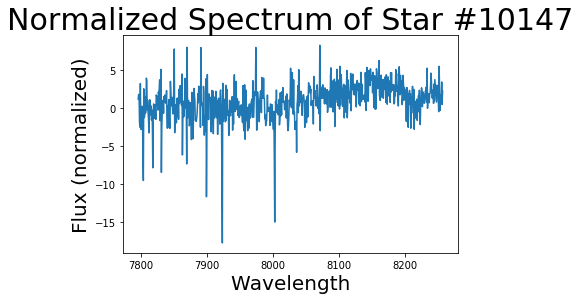

In [19]:
#graphs the normalized spectrum of any star in SPLASH
#inclues the option to graph an already-made template spectrum alongside the normalized spectrum
def graphNormSpec(star = None, spectrum = None, lower = lowerThresh, upper = upperThresh, template = False, templateSpec = None, fileName = None):
    '''
    star: the index of a particular star (with corresponding spectrum) in SPLASH
    spectrum: a Numpy array consisting of the data values that represent the flux values of a spectrum to be graphed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    template: a Boolean variable that, if True, will graph the normalized spectrum and the template spectrum on the same graph. If False, only the normalized spectrum will be graphed
    templateSpec: a Numpy array representing the flux values of the spectrum to be used as the template if template is True
    fileName: an optional argument that can be used to save the created graph as a png with the file name designated
    
    Note that in order to use the template, the functions below that are devoted to template creation must be initialized
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    template will default to False, and templateSpec will default to Ctemplate (the carbon coadd)
    star and spectrum will default to None so that either a star index or raw spectral data can be used in the function. Use the inputs that you need based on your data type and leave the other as None
    fileName will default to None, meaning the graph will not be saved as a png
   
    
    Does not return a particular value, but will produce a graph of wavelength versus flux that represents the normalized spectrum of star
    Note that gaps may be present in the spectral graph where NaN values are present in the flux measurements of a certain star
    '''
    #assigning the data to be graphed
    if star is None and np.all(spectrum is None):
        print("InputError: One of 'star' and 'spectrum' must not be None.")
        return None
    if star is not None:
        wvrange, spectrum, ivar = normSpec(star = star, lower = lower, upper = upper)[:3]
    elif np.all(spectrum is not None):
        wvrange, spectrum = data["LBIN"][0][lower:upper], spectrum
    x = wvrange.tolist()
    y = spectrum.tolist()
    
    #this if statement separates out the graphing data that is assigned if template is True
    if template is True:  #Antara - changed the default template to Wtemplate (weak CN coadd)
        y2 = templateSpec
        plt.plot(x, y, color = "b", label = "Normalized Spectrum")
        plt.plot(x, y2, color = "r", label = "Template Spectrum")
        plt.legend(fontsize = 20)
    else:
        plt.plot(x,y)
    
    #formatting the graph so that it is easily readable and executing its creation
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Normalized Spectrum of Star #" + str(star), size = 30) 
    plt.ylabel("Flux (normalized)", size = 20)
    plt.xlabel("Wavelength", size = 20) 
    if fileName is not None:
        plt.savefig(fileName)
    else:
        plt.show()

#test execution of the function
graphNormSpec(star = 10147)

## Coadding Spectra
Includes sigma clipping for normalized spectral data, coaddition, and graphing functions. Also includes a Gaussian function to smooth spectral graphs. Creates three template spectra to be used in later score calculation methods; these include both a clipped and full-range carbon star template as well as a weak CN star template.

In [21]:
#defines a function that clips out outlier data points in a set of spectra 
#outliers are defined as points that lie outside of a certain number of standard deviations away from the median flux value at each wavelength
def sigmaClip(spectra, ivars, nsigma = 3.5):
    '''
    spectra: a list of the spectra of each star that is being clipped
    ivars: a list of the sets of ivars for each star that is being coadded
    nsigma: an integer or float representing the number of standard deviations away from the median to be used in clipping
    
    nsigma will default to 3.5 unless otherwise specified
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns spectra, a list of the spectra of each star in terms of flux
    Also returns ivars, a list of the set of ivars of each star with values corresponding to the invalid values in spectra (those that lie more than nsigma standard deviations away from the median) replaced by 0s
    '''
    sortedSpecList = []
    for value in range(len(spectra[1])): #note that the use of spectra[1] is arbitrary as all of the lists in spectra have the same length
        listToAdd = []
        for spectrum in range(len(spectra)):
            if not np.isnan(spectra[spectrum][value]):
                listToAdd.append(spectra[spectrum][value])
        sortedSpecList.append(listToAdd)
    medians = []
    for eachlist in range(len(sortedSpecList)):
        if len(sortedSpecList[eachlist]) != 0:
            medians.append(st.median(sortedSpecList[eachlist]))
        else: 
            medians.append(np.nan)
        if eachlist%100 == 0 and eachlist != 0:
            print(str(eachlist) + " medians calculated.")
    for spectrum in range(len(spectra)):
        for flux in range(len(spectra[1])): #see above comment
            if np.isnan(medians[flux]):
                continue
            elif ivars[spectrum][flux] != 0 and not np.isnan(spectra[spectrum][flux]):
                testFlux = ((spectra[spectrum][flux] - medians[flux])**2)*ivars[spectrum][flux] 
                if testFlux > nsigma**2:
                    spectra[spectrum][flux] = np.nan
                    ivars[spectrum][flux] = 0          
    return spectra, ivars

In [22]:
#defines a function that will coadd normalized spectra based on provided lists of spectra and ivar weights
def coadd(spectra, ivars, lower = lowerThresh, upper = upperThresh):
    '''
    spectra: a list of the spectra of each star that is being coadded
    ivars: a list of the sets of ivars for each star that is being coadded
    lower: the lower boundary of the range the spectrum have been normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum have been normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns wvValues_np, a Numpy array containing every wavelength value for which spectral data exists between lower and upper
    Also returns coaddedFlux_np, a Numpy array containing the flux values of the coadded spectrum corresponding to each wavelength in wvValues_np 
    Also returns coaddedIvar_np, a Numpy array containing the ivar values of the coadded spectrum corresponding to each wavelength in  wvValues_np
    '''
    wvValues = data["LBIN"][0][lower:upper].tolist()
    coaddedFlux = []
    coaddedIvar = []
    for wv in range(len(wvValues)):
        fluxSum = 0
        ivarSum = 0
        for star in range(len(spectra)):
            if not np.isnan(spectra[star][wv]): 
                fluxSum += spectra[star][wv] * ivars[star][wv] #multiplying by ivar as a weight, as per formula
                ivarSum += ivars[star][wv]
        if ivarSum == 0:
            coaddedFlux.append(np.nan)
            coaddedIvar.append(0)
        else:
            newFlux = fluxSum/ivarSum #normalizing the weights, as per formula
            coaddedFlux.append(newFlux) #coaddedSpec now contains a coadded spectrum value at each LBIN value
            coaddedIvar.append(ivarSum) #coadded ivar is simply the sum of all ivars for a certain bin, across all stars (based on a mathematical proof)
    for flux in range(len(coaddedFlux)):
        if coaddedFlux[flux] == 0:
            coaddedFlux[flux] = np.nan
    coaddedFlux_np = np.array(coaddedFlux)
    wvValues_np = np.array(wvValues)
    coaddedIvar_np = np.array(coaddedIvar)
    return wvValues_np, coaddedFlux_np, coaddedIvar_np

In [23]:
#defines a function that applys a smoothing function to a spectrum to improve the quality of the spectrum's graph
#used in this program largely for smoothing the graphs of template spectra
def applyGauss(spectrum, gauss = 2):
    '''
    spectrum: a Numpy array containing the flux values of a pre-clipped and normalized (if applicable) star spectrum that will be smoothed
    gauss: an optional numerical argument to be used as the standard deviation of the Gaussian kernel
    
    gauss will default to 2 if no other value is provided (this value was determined based on previous work by A. Kamath)
    
    Returns smoothSpec, a Numpy array containing the modified/smoothed flux values of the original spectrum
    '''
    kernel = Gaussian1DKernel(gauss)
    smoothSpec = convolve(spectrum, kernel)
    return smoothSpec

In [24]:
#defines a function that will coadd normalized spectra based on provided lists of spectra and ivar weights
def coadd(spectra, ivars, lower = lowerThresh, upper = upperThresh):
    '''
    spectra: a list of the spectra of each star that is being coadded
    ivars: a list of the sets of ivars for each star that is being coadded
    lower: the lower boundary of the range the spectrum have been normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum have been normalized on, in terms of wavelength
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    spectra and ivar values must be normalized and corresponding for best results
    
    Returns wvValues_np, a Numpy array containing every wavelength value for which spectral data exists between lower and upper
    Also returns coaddedFlux_np, a Numpy array containing the flux values of the coadded spectrum corresponding to each wavelength in wvValues_np 
    Also returns coaddedIvar_np, a Numpy array containing the ivar values of the coadded spectrum corresponding to each wavelength in  wvValues_np
    '''
    wvValues = data["LBIN"][0][lower:upper].tolist()
    coaddedFlux = []
    coaddedIvar = []
    for wv in range(len(wvValues)):
        fluxSum = 0
        ivarSum = 0
        for star in range(len(spectra)):
            if not np.isnan(spectra[star][wv]): 
                fluxSum += spectra[star][wv] * ivars[star][wv] #multiplying by ivar as a weight, as per formula
                ivarSum += ivars[star][wv]
        if ivarSum == 0:
            coaddedFlux.append(np.nan)
            coaddedIvar.append(0)
        else:
            newFlux = fluxSum/ivarSum #normalizing the weights, as per formula
            coaddedFlux.append(newFlux) #coaddedSpec now contains a coadded spectrum value at each LBIN value
            coaddedIvar.append(ivarSum) #coadded ivar is simply the sum of all ivars for a certain bin, across all stars (based on a mathematical proof)
    for flux in range(len(coaddedFlux)):
        if coaddedFlux[flux] == 0:
            coaddedFlux[flux] = np.nan
    coaddedFlux_np = np.array(coaddedFlux)
    wvValues_np = np.array(wvValues)
    coaddedIvar_np = np.array(coaddedIvar)
    return wvValues_np, coaddedFlux_np, coaddedIvar_np

In [25]:
#defines a function that creates a coadded template spectrum by combining several spectra normalized over a certain range
def getTempSpec(starIndices, lower = lowerThresh, upper = upperThresh, nsigma = 3.5):
    '''
    starIndices: an array or list of the indices of the stars to be coadded (which correspond to spectra in SPLASH)
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength
    nsigma: a numerical value representing the number of standard deviations away from the flux medians that data for the coaddition will be trimmed to
    
    lower and upper will default to the lowerThresh and upperThresh values defined above, respectively
    nsigma will default to 3.5 unless another value is provided
    
    Returns coadd_wv, the set of all wavelength values for which data exists in the final coadded spectrum
    Also returns coadd_spec, the set of all flux values that correspond to the wavelength values in coadd_wv for the final coadded spectrum
    Also returns coadd_ivar, the number representing the ivar for every wavelength value on the final coadded spectrum
    Note that the final spectrum has been created from nsigma clipped data
    '''
    #creating lists of normalized spectra and ivars for each star to be coadded
    spectra = []
    ivars = []
    for star in starIndices:
        if lower == lowerThresh and upper == upperThresh:
            #spectra.append(applyGauss(splashSpecs_dict[star],gauss=6).tolist())
            spectra.append(splashSpecs_dict[star].tolist())
            ivars.append(splashIvars_dict[star].tolist())
        else:
            starSpec, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
            #starSpec = applyGauss(starSpec,gauss=6)
            spectra.append(starSpec.tolist())
            ivars.append(starIvar.tolist())
    print("Step 1 of 3 complete. Normalized spectra and inverse variances loaded.")

    #takes the original data and replaces with NaN values any data points that are greater than nsigma standard deviations from the median
    #the median is defined as the median flux at each wavelength when the flux values for every spectrum at that wavelength are considered
    spectra_new, ivars_new = sigmaClip(spectra, ivars, nsigma)
    print("Step 2 of 3 complete. Spectral and ivar data clipped to " + str(nsigma) + " sigmas.")

    #performs the coaddition with the edited data from the last step
    coadd_wv, coadd_spec, coadd_ivar = coadd(spectra_new, ivars_new, lower, upper)
    print("Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.")
    
    return coadd_wv, coadd_spec, coadd_ivar

In [26]:
Ctemplate_wv, Ctemplate, Ctemplate_ivar = getTempSpec(allcarbon)
Ctemplate_wv_full, Ctemplate_full, Ctemplate_ivar_full = getTempSpec(allcarbon, lower = fullSpec_low, upper = fullSpec_high)
Wtemplate_wv, Wtemplate, Wtemplate_ivar = getTempSpec(wNm)
Wtemplate_wv_full, Wtemplate_full, Wtemplate_ivar_full = getTempSpec(wNm, lower = fullSpec_low, upper = fullSpec_high)

Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
Step 2 of 3 complete. Spectral and ivar data clipped to 3.5 sigmas.
Step 3 of 3 complete. Coaddition of spectra and ivars performed and template created.
Step 1 of 3 complete. Normalized spectra and inverse variances loaded.
100 medians calculated.
200 medians calculated.
300 medians calculated.
400 medians calculated.
500 medians calculated.
600 medians calculated.
700 medians calculated.
800 medians calculated.
900 medians calculated.
1000 medians calculated.
1100 medians calculated.
1200 medians calculated.
1300 medians calculated.
1400 medians calculated.
1500 medians calculated.
1600 medians calculated.
1700 medians calculated.
1800 medians calculated.
1900 medians calculated.
2000 medians calculated.
2100 medians calculated.
2200 medians calcula

# FUNCTIONS
All the functions from past notebooks have been copied in one spot.

In [27]:
def defaultHist(data, binList, colors, labels, graphLabels, xLim = None, yLim = None, dens=False,alphas = None, step = 0, fileName = None):
    '''
    main note on this function: everything should be passed in as a tuple - even if a single value, put [ ] around
   
    data: a tuple containing all the lists of data to plot on the same histogram
    binList: the Numpy array to use as bins (used for ALL data populations)
    colors: a tuple containing all the colors, corresponding to each sample in data
    labels: a tuple containing all the labels, corresponding to each sample in data
    graphLabels: a tuple of length 3 containing data for the graph: (1) title, (2) x-label, (3) y-label
    dens: a boolean that, if True, will make the histogram a density histogram - default is False
    xLim, yLim: if not None, the limits to put on the viewing rectangle of the graph
    alphas: a tuple of alpha values (transparency amounts) - default is None (no transparency)
    step: if greater than 0, implies a step histogram should be used. value is the line width for the histogram
    fileName: if not None, means this plot should be saved as a figure with this file name.
    '''
    
    for index in range(len(data)):
        a = 1
        if not alphas is None:
            a = alphas[index]
        if step > 0:
            plt.hist(data[index], bins = binList, color = colors[index], label = labels[index], histtype='step', linewidth = step, density = dens, alpha = a)
        else:
            plt.hist(data[index], bins = binList, color = colors[index], label = labels[index], density = dens, alpha = a)
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title(graphLabels[0], size = 50) 
    plt.xlabel(graphLabels[1], size = 40)
    plt.ylabel(graphLabels[2], size = 40)
    plt.legend(fontsize = 35)

    if xLim is not None:
        plt.xlim(xLim)
    if yLim is not None:
        plt.ylim(yLim)
    
    if fileName is not None:
        plt.savefig(fileName)

    plt.show()



#helper function for trimStars
#defines a function which will give a fraction (probability) to run through trimStars, based on bin-based-ratio
def ratioLim(sampleData, medIvar, ratio, modelData):   
    '''
    algorithm
    a. find bin which this ivar falls under
    b. multiply the count of weakCN/carbon (model population) by the constant ratio previously created for that bin
    c. divide the result of (b) by the total number of stars in the current bin from the kphOthers population (the one to trim)
    
    sampleData: the dataset that you wish to clip/modify based on ivar
    medIvar: the ivar to operate with
    ratio: a numerical value representing the ratio of other stars population to model carbon/weak CN population previously found 
    modelData: the dataset that you are trying to match the sampleData to through ivar clipping
    buckets: the buckets with which to operate - if the log-ivar histogram bins are changed, then this must be changed as well
    
    Note that buckets will default to an array from 0 to 6 with a step size of 0.25 unless otherwise assigned
    
    Returns a numerical value representing a probability that will be used to choose a certain number of stars from the sample population
    '''
    buckets = sampleData[1]
    logIv = np.log(medIvar)/np.log(10)
    step = buckets[1] - buckets[0]
    index = int((logIv - buckets[0])/step)
    goalCount = ratio*modelData[0][index]
    return goalCount/sampleData[0][index]

#defines a function that takes in a sample of stars and trims that sample according to the ivars of those stars
def trimStars(starSample, medIvDict, modelData, ratio, sampleData):
    '''
    starSample: the sample of stars that you wish to trim based on ivar
    medIvDict: a dictionary of the median ivars for the stars in starSample; keys are the indices of the stars and values are the median ivars
    modelData: the model histogram data for bin-based ratio calculation (wNm_logHighData or carb_logHighData)
    ratio: the ratio of other:model to use for trimming the starSample dataset
    sampleData: the sample histogram data for bin-based ratio calculation (kphO_logHighData); a 2D array representing the histogram frequencies/bins that were used to find the ratio
    
    Returns pickStar, an array of Boolean values corresponding to the stars in starSample. True indicates that the star should be selected and False indicates that it should not be selected
    Also returns trimmed_ivarMeds, an array containing the median ivar values for each of the stars in the new trimmed sample. In other words, these median ivars correspond to the "True"s in the pickStar array
    '''
    pickStar = np.zeros(len(starSample), dtype = bool)
    trimmed_ivarMeds = []
    index = 0
    for star in starSample: #set to choose from is keckPhotoOthers (not the entire others set)
        if star not in medIvDict:
            index += 1 #must actually skip this index in pickStar, on top of just moving to next star
            continue
        starMedIvar = medIvDict[star]
        
        #find the fraction to pick, and thus probability of picking, based on the function: limFunc(starMedIvar)
        pickFraction = ratioLim(sampleData, starMedIvar, ratio, modelData)
        if random.random() < pickFraction: #random.random() generates a floating point number from [0.0, 1.0)
            pickStar[index] = True #this star will be picked for the new sample
            trimmed_ivarMeds.append(starMedIvar) #add this star's median ivar to a list, to plot in the new normalized histogram
        index += 1
    return pickStar, trimmed_ivarMeds

#creates a function that calculates the score (a measure of the difference between two spectra) for a certain star's spectrum compared to a certain template spectrum
#note that the input spectra and ivars must be already sliced and normalized
def getScore(templateSpec, scienceSpec, ivars):
    '''
    templateSpec: a Numpy array containing the flux values of the coadded template spectrum
    scienceSpec: a Numpy array containing the flux values at each wavelength of the normalized spectrum for a specific star
    ivars: a Numpy array containing the normalized ivar values at each wavelength of the spectrum for a specific star
    
    Returns finalScore, a float representing the similarity between the two spectra. A lower score indicates greater similarity and a higher score indicates lower similarity
    Note that spectra that cannot be normalized will not have a score associated with them. The function returns a NaN as the score for these spectra
    '''
    templateSpec_list = templateSpec.tolist()
    scienceSpec_list = scienceSpec[~np.isnan(scienceSpec)].tolist()
    if scienceSpec_list == []:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan
    else:
        summedScore = 0
        for wv in range(len(templateSpec_list)):
            score = ((scienceSpec[wv] - templateSpec[wv])**2) * ivars[wv]
            if not np.isnan(score):
                summedScore += score
        summedIvars = 0
        for ivar in ivars:
            if not np.isnan(ivar):
                summedIvars += ivar
        finalScore = (summedScore/summedIvars)**0.5
        return finalScore

#test execution of function
specStar, ivarStar = splashSpecs_dict[19534],splashIvars_dict[19534]
print("Score: " + str(getScore(Wtemplate, specStar, ivarStar)))


#MODIFIED TEMPLATE FUNCTIONS

#defines a function that calculates the slope of a spectrum's wavelength vs flux graph on a certain interval
def getSlope(spectrum, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a list containing the sliced, normalized flux values of the spectrum to be analyzed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    
    lower and upper will default to the previously defined lowerThresh and upperThresh values, respectively
    
    Returns slope, a numerical value representing the slope of the spectrum on the wavelength range lower to upper
    '''
    lowerInt, upperInt, = spectrum[:slopeWindow], spectrum[-slopeWindow:]
    lowerMedian = np.nanmedian(lowerInt)
    upperMedian = np.nanmedian(upperInt)
    diff = (data['LBIN'][0][upper] - data['LBIN'][0][lower])
    slope = (upperMedian - lowerMedian)/diff
    return slope

#defines a function that modifies the slope of a spectrum by distorting the graph
def getTiltedSpec(spectrum, slope, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be modified
    slope: a numerical value (most often a float) containing the slope to be applied to the spectrum
    lower: the index of the lower boundary of spectrum in data["LBIN"]
    upper: the index of the upper boundary of spectrum in data["LBIN"]
    
    Note that lower and upper will default to the predefined lowerThresh and upperThresh, respectively
    
    Returns titled, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    deltaLam = data['LBIN'][0][lower:upper] - data['LBIN'][0][lower] #note that the used of data["LBIN"][0] is arbitrary because all spectra have the same LBIN data values
    tilted = slope*deltaLam + spectrum #creating a copy of the spectrum with the new slope
    tilted = tilted/np.nanmedian(tilted) #normalizes the spectrum again
    return tilted

#defines a function that scales a spectrum by either enhancing or reducing spectral features
def getScaledSpec(spectrum, c):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be scaled
    c: a numerical value representing the scale factor by which the spectrum will be modified
    
    Returns scaledFlux, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    if c == -1: #accounts for potential divide by zero errors in scaling function
        raise ZeroDivisionError("c cannot be -1 due to the structure of the scaling formula.")
    scaledFlux = (spectrum + c)/(1+c)
    return scaledFlux

#defines a helper function for findOptimalC that produces a list of all the c-values to be tested
def getRanger(start, stop, step, zoomStart = None, zoomStop = None, zoomStep = None):
    '''
    start: a numerical value representing the lowest value of c you want to test
    stop: a numerical value representing the highest value of c you want to test
    step: a numerical value representing the increment at which you want to create new values of c between start and stop
    zoomStart: a numerical value representing the lowest value of c you want to test with a finer step size
    zoomStop: a numerical value representing the highest value of c you want to test with a finer step size
    zoomStep: a numerical value representing the finer step size to be applied between zoomStop and zoomStart
    
    Note that zoomStart, zoomStop, and zoomStep will all default to None.
    
    Returns rangeList, a list of the scale-factor (c) values to be iterated over for a star that is undergoing the template-matching process
    '''
    rangeList = []
    i = start
    if zoomStart == None:
        zoomStart = start 
        zoomStop = stop
        zoomStep = step
    while i < stop:
        rangeList.append(i)
        if i >= zoomStart and i <= zoomStop: #'zooms in' on a part of the c-range to get smaller c increments just on that range
            i += zoomStep 
        else:
            i += step
    return rangeList

#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findOptimalC(star, template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    for c in getRanger(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec(clipTemplate, c)
        s = slope - getSlope(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModTemplate(star, c , template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
   # if gauss:
    #    clipTemplate = applyGauss(clipTemplate, nsigma)
      #  starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    scaledFlux = getScaledSpec(clipTemplate, c)
    s = slope - getSlope(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findWOptimalC(star, template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    for c in getRanger(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec(clipTemplate, c)
        s = slope - getSlope(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModWTemplate(star, c , template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
   # if gauss:
    #    clipTemplate = applyGauss(clipTemplate, nsigma)
      #  starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope(starFlux, lower, upper)
    scaledFlux = getScaledSpec(clipTemplate, c)
    s = slope - getSlope(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

#MODIFIED UNDILUTED
#defines an important variable that will be used for finding the slopes of spectra
#the slope will not be calculated based on random points, but on the median point in a small "window" at either end of the spectrum
slopeWindow = 25

#defines a function that calculates the slope of a spectrum's wavelength vs flux graph on a certain interval
def getSlope2(spectrum, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a list containing the sliced, normalized flux values of the spectrum to be analyzed
    lower: the lower boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    upper: the upper boundary of the range the spectrum will be normalized on, in terms of wavelength index in data["LBIN"]
    
    lower and upper will default to the previously defined lowerThresh and upperThresh values, respectively
    
    Returns slope, a numerical value representing the slope of the spectrum on the wavelength range lower to upper
    '''
    lowerInt, upperInt, = spectrum[:slopeWindow], spectrum[-slopeWindow:]
    lowerMedian = np.nanmedian(lowerInt)
    upperMedian = np.nanmedian(upperInt)
    diff = (data['LBIN'][0][upper] - data['LBIN'][0][lower])
    slope = (upperMedian - lowerMedian)/diff
    return slope

#defines a function that modifies the slope of a spectrum by distorting the graph
def getTiltedSpec2(spectrum, slope, lower = lowerThresh, upper = upperThresh):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be modified
    slope: a numerical value (most often a float) containing the slope to be applied to the spectrum
    lower: the index of the lower boundary of spectrum in data["LBIN"]
    upper: the index of the upper boundary of spectrum in data["LBIN"]
    
    Note that lower and upper will default to the predefined lowerThresh and upperThresh, respectively
    
    Returns titled, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    deltaLam = data['LBIN'][0][lower:upper] - data['LBIN'][0][lower] #note that the used of data["LBIN"][0] is arbitrary because all spectra have the same LBIN data values
    tilted = slope*deltaLam + spectrum #creating a copy of the spectrum with the new slope
    tilted = tilted/np.nanmedian(tilted) #normalizes the spectrum again
    return tilted

#defines a function that scales a spectrum by either enhancing or reducing spectral features
def getScaledSpec2(spectrum, c):
    '''
    spectrum: a Numpy array containing the flux values of a (likely normalized) star spectrum to be scaled
    c: a numerical value representing the scale factor by which the spectrum will be modified
    
    Returns scaledFlux, a Numpy array containing the flux values of the adjusted star spectrum
    '''
    if c == -1: #accounts for potential divide by zero errors in scaling function
        raise ZeroDivisionError("c cannot be -1 due to the structure of the scaling formula.")
    scaledFlux = (spectrum + c)/(1+c)
    return scaledFlux


#defines a helper function for findOptimalC that produces a list of all the c-values to be tested
def getRanger2(start, stop, step, zoomStart = None, zoomStop = None, zoomStep = None):
    '''
    start: a numerical value representing the lowest value of c you want to test
    stop: a numerical value representing the highest value of c you want to test
    step: a numerical value representing the increment at which you want to create new values of c between start and stop
    zoomStart: a numerical value representing the lowest value of c you want to test with a finer step size
    zoomStop: a numerical value representing the highest value of c you want to test with a finer step size
    zoomStep: a numerical value representing the finer step size to be applied between zoomStop and zoomStart
    
    Note that zoomStart, zoomStop, and zoomStep will all default to None.
    
    Returns rangeList, a list of the scale-factor (c) values to be iterated over for a star that is undergoing the template-matching process
    '''
    rangeList = []
    c = 0
    rangeList.append(c)
    return rangeList
    
    #Previous code from 2.6
    ''' 
    if zoomStart == None:
        zoomStart = start 
        zoomStop = stop
        zoomStep = step
    while i < stop:
        rangeList.append(i)
        if i >= zoomStart and i <= zoomStop: #'zooms in' on a part of the c-range to get smaller c increments just on that range
            i += zoomStep 
        else:
            i += step
    return rangeList
    '''

#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findWOptimalC2(star, template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    for c in getRanger2(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec2(clipTemplate, c)
        s = slope - getSlope2(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModWTemplate2(star, c=0, template = Wtemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    scaledFlux = getScaledSpec2(clipTemplate, c)
    s = slope - getSlope2(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

#defines a function that sorts through the c-values produced by getRanger and returns the c-value and s-value that result in the lowest score
def findCOptimalC2(star, template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, lowC = -15, highC = 60, step = 0.5, zoomStart = None, zoomStop = None, zoomStep = None, trackC = False, gauss = False, nsigma = 10):
    '''
    Note that default argument values have been denoted with () in the descriptions below
    
    star: the index of the star for which the template is to be modified to fit and the score is to be calculated
    template: (Ctemplate_full) the template spectrum that will be used to compare the spectrum of star to
    lower: (lowerThresh) the lower boundary for the spectra of star and template to be normalized on/analyzed on
    upper: (upperThresh) the upper boundary for the spectra of star and template to be normalized on/analyzed on
    lowC: (-15) the lower boundary for the range of c-values to be tested
    highC: (60) the upper boundary for the range of c-values to be tested
    step: (0.5) the increment by which c-values between lowC and highC are tested
    zoomStart: (None) the lower boundary for a range of c-values to be tested with a finer increment size
    zoomStop: (None) the upper boundary for a range of c-values to be tested with a finer increment size
    zoomStep: (None) the finer increment size by which c-values between zoomStart and zoomStop are tested
    trackC: (False) a Boolean value that, if True, will produce a graph of c-values and their corresponding scores as the function steps through the c-range; if False, the graph will not be produced
    gauss: (False) a Boolean value that, if True, will apply a Gaussian smoothing kernel to both the template and science spectra before optimal C is found
    nsigma: (10) a numerical value representing the width of the Gaussian kernel that will be used if gauss is True
    
    Returns bestC, the scale factor that yielded the lowest score
    Also returns bestS, the slope that yielded the lowest score (note that this is the version of the slope that has been changed according to the scaled spectrum)
    Also returns bestScore, the "lowest score" referred to above
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("ScoreError: Because this spectrum cannot be normalized, its score cannot be found.")
        return np.nan, np.nan, np.nan
    bestScore = None
    bestC, bestS = 0, 0
    c_coords, sc_coords = [], []
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    for c in getRanger2(lowC, highC, step, zoomStart, zoomStop, zoomStep):
        if c == -1:
            continue
        scaledFlux = getScaledSpec2(clipTemplate, c)
        s = slope - getSlope2(scaledFlux, lower, upper)
        tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
        testScore = getScore(tiltedFlux, starFlux, starIvar)
        if trackC:
            c_coords.append(c)
            sc_coords.append(testScore)
        if bestScore == None or testScore < bestScore:
            bestC, bestS = c, s
            bestScore = testScore
    if trackC:
        plt.plot(c_coords, sc_coords)
        plt.rcParams['figure.figsize'] = 30,11 
        plt.title("C-Value vs. Score for Star " + str(star), size = 30) 
        plt.ylabel("Score", size = 20)
        plt.xlabel("C (Scale) Value", size = 20)
        plt.legend(fontsize = 20)
        plt.ylim(0,0.2)
        plt.show()
    return bestC, bestS, bestScore

#defines a function that allows a user to see the modified template "findOptimalC" chose as the best match for a star
def seeModCTemplate2(star, c=0, template = Ctemplate_full, lower = lowerThresh, upper = upperThresh, starSpec = True, unmodified = False, gauss = False, nsigma = 10):
    '''
    star: the index number of the star that was analyzed with findOptimalC
    c: the c (scale) value that was produced when findOptimalC was run on star
    template: the template spectrum to be modified
    lower: the lower boundary on which the template spectrum is to be modified
    upper: the upper boundary on which the template spectrum is to be modified
    starSpec: a Boolean value that, if True, will graph star's science spectrum along with the modified template; if False, only the modified template will be graphed
    unmodified: a Boolean value that, if True, will graph the unmodified template along with the modified template; if False, only the modified template will be graphed
    
    Note that template, lower, upper, starSpec, and unmodified default to Ctemplate_full, lowerThresh, upperThresh, True, and False
    
    This function will return None while also producing a graph of the modified template spectrum along with any other auxilary graphs chosen by the user based on inputs
    '''
    if not normSpec(star = star, lower = lower, upper = upper)[3]:
        print("NormalizationError: Because this spectrum cannot be normalized, this method cannot be applied to it.")
        return None
    clipTemplate = template[lower:upper]
    starFlux, starIvar = normSpec(star = star, lower = lower, upper = upper)[1:3]
    if gauss:
        clipTemplate = applyGauss(clipTemplate, nsigma)
        starFlux = applyGauss(starFlux, nsigma)
    while all(np.isnan(starFlux[:slopeWindow])) or all(starFlux[:slopeWindow] == 0):
        starFlux, starIvar, clipTemplate = starFlux[slopeWindow:], starIvar[slopeWindow:], clipTemplate[slopeWindow:]
        lower += slopeWindow
    while all(np.isnan(starFlux[-slopeWindow:])) or all(starFlux[-slopeWindow:] == 0):
        starFlux, starIvar, clipTemplate = starFlux[:-slopeWindow], starIvar[:-slopeWindow], clipTemplate[:-slopeWindow]
        upper -= slopeWindow
    slope = getSlope2(starFlux, lower, upper)
    scaledFlux = getScaledSpec2(clipTemplate, c)
    s = slope - getSlope2(scaledFlux, lower, upper)
    tiltedFlux = getTiltedSpec2(scaledFlux, s, lower, upper)
    plt.plot(data["LBIN"][0][lower:upper], tiltedFlux, color = 'b', label = ('Modified Template (C = ' + str(c) +')'))
    if starSpec:
        plt.plot(data["LBIN"][0][lower:upper], starFlux, color = 'orange', label = 'Science Spectrum')
    if unmodified:
        plt.plot(data["LBIN"][0][lower:upper], clipTemplate, label = 'Unmodified Template')
    plt.rcParams['figure.figsize'] = 30,11 
    plt.title("Modified Template Comparison for Star " + str(star), size = 30) 
    plt.ylabel("Flux", size = 20)
    plt.xlabel("Wavelength", size = 20)
    plt.legend(fontsize = 20)
    plt.show()

#SLOPES

#defines a helper function for the getWSlopes function that determines what the slope of the line of best fit is for a certain graph
def findOptimalM(spectrum, lower, upper, lowM = -0.1, highM = 0.1, step = 0.001, zoomStart = -0.05, zoomStop = 0.05, zoomStep = 0.0001):
    '''
    spectrum: a Numpy array representing the flux values of a normalized, clipped (to the 'W' range) spectrum whose slopes are to be found
    lower: the lower boundary of the range that the slope is to be calculated over (represented by an index of the CLIPPED spectrum; 0 will be lowerThresh and so on)
    upper: the upper boundary of the range that the slope is to be calculated over (represented by an index of the CLIPPED spectrum; 0 will be lowerThresh and so on)
    lowM: the lower boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    highM: the upper boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    step: the increment value to use when creating new values of m to test between lowM and highM
    zoomStart: the lower boundary of the range of m-values that you want to test with a finer step size
    zoomStop: the upper boundary of the range of m-values that you want to test with a finer step size
    zoomStep: the finer increment value to be applied between zoomStart and zoomStop
    
    Note that lowM, highM, step, zoomStart, zoomStop, and zoomStep will default to -0.1, 0.1, 0.05, -0.05, 0.05, and 0.001, respectively
    
    Returns bestM, a numerical value representing the slope of the line of best fit for the spectrum on the range lower:upper
    Also returns bestB, the y-intercept value that corresponds to the bestM, to be used for graphing the chosen lines of best fit
    '''
    bestDiff, bestM, bestB = 1000000000000, None, None
    lbin = data["LBIN"][0][lowerThresh:upperThresh][lower:upper]
    mRanger = getRanger(lowM, highM, step, zoomStart, zoomStop, zoomStep) #note that this is the same function earlier defined in score calculation method 2
    for m in mRanger:
        b = ((np.nansum(spectrum)) - (m*(np.nansum(lbin))))/(len(lbin))
        testDiff = np.nansum(np.power((spectrum - m*lbin - b), 2))
        if testDiff < bestDiff:
            bestDiff = testDiff
            bestM, bestB = m, b
    return bestM, bestB

#defines a function that will check to see if the range covered by non-NaN values in a spectrum slice is greater than/equal to 75% of the length of the spectrum
#if the above condition is not met, the slope of the slice cannot be calculated
def isValidWindow(spectrum, windowLower, windowUpper):
    '''
    spectrum: a Numpy array containing the flux values of a normalized, trimmed (clipped to the 'W' range) spectrum whose slope is to be calculated
    windowLower: the lower boundary of the window of spectrum whose validity is to be tested
    windowUpper: the upper boundary of the window of spectrum whose validity is to be tested
    
    Returns False if the window specified has too many NaN values to be used for slope calculation, True otherwise
    '''
    testSpec = spectrum[windowLower:windowUpper]
    count1, count2 = windowLower, windowUpper
    for index in range(len(testSpec)): #finding the index of the first non-NaN value
        if np.isnan(testSpec[index]):
            count1 = index
        else:
            break
    for index in range(len(testSpec), 0, -1): #finding the index of the last non-NaN value
        if np.isnan(testSpec[index - 1]):
            count2 = index
        else:
            break
    if len(testSpec[count1:count2]) < 0.75*len(testSpec): #the range covered by the two indices found above must be greater than or equal to the length of the spectrum to be usable
        return False
    else:
        return True
    
#defines a function that calculates four slopes of a spectral graph
def getWSlopes(spectrum, lowM = -0.1, highM = 0.1, step = 0.001, zoomStart = -0.05, zoomStop = 0.05, zoomStep = 0.0001, getB = False):
    '''
    spectrum: a Numpy array or list containing the flux values for a spectrum whose slopes will be calculated; must already be normalized/clipped to the lowerThresh:upperThresh wavelength range
    lowM: the lower boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    highM: the upper boundary of the range of m-values (slope values) to be tested when searching for the line of best fit
    step: the increment value to use when creating new values of m to test between lowM and highM
    zoomStart: the lower boundary of the range of m-values that you want to test with a finer step size
    zoomStop: the upper boundary of the range of m-values that you want to test with a finer step size
    zoomStep: the finer increment value to be applied between zoomStart and zoomStop
    getB: a Boolean value that, if set to True, will cause the function to return both slope and y-intercept values for the lines of best fit created (if False, only slopes will be returned)
    
    Note that lowM, highM, step, zoomStart, zoomStop, zoomStep, and getB will default to -0.1, 0.1, 0.05, -0.05, 0.05, 0.001, and False, respectively
    
    Returns slope1, slope2, slope3, and slope4, the slopes of the spectral graph over the window ranges described above; these slopes are intended to represent the four slopes of the 'W' feature in carbon/weak CN spectra
    If getB is set to True, also returns the y-intercept values for the lines of best fit corresponding to slope1, slope2, slope3, and slope4
    '''
    #first, a preliminary check to see if the entire spectrum is NaN; if True, all returned slopes are NaN as well
    if all(np.isnan(spectrum)):
        print("SlopeError: This spectrum is all NaNs. No slopes can be found.")
        return np.nan, np.nan, np.nan, np.nan
    
    #if the above test is passed, the spectrum is divided into four windows
    window1, window2 = spectrum[windows[0][0]:windows[0][1]], spectrum[windows[1][0]:windows[1][1]]
    window3, window4 = spectrum[windows[2][0]:windows[2][1]], spectrum[windows[3][0]:windows[3][1]]
    calc1, calc2, calc3, calc4 = True, True, True, True
    
    #tests are done on each window to make sure that the presence of NaNs will not ruin the slope calculation
    #if the calculation cannot be performed, the calcX variables are set to False (meaning those slopes will not be calculated later) and the slopes to be returned are set to NaN
    if all(np.isnan(window1)) or not isValidWindow(spectrum, windows2[0][0], windows2[0][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 1. Slope1 could not be found.")
        slope1, calc1 = np.nan, False
    if all(np.isnan(window2)) or not isValidWindow(spectrum, windows2[1][0], windows2[1][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 2. Slope2 could not be found.")
        slope2, calc2 = np.nan, False
    if all(np.isnan(window3)) or not isValidWindow(spectrum, windows2[2][0], windows2[2][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 3. Slope3 could not be found.")
        slope3, calc3 = np.nan, False
    if all(np.isnan(window4)) or not isValidWindow(spectrum, windows2[3][0], windows2[3][1]):
        print("SlopeError: This spectrum is dominated by NaNs in window 4. Slope4 could not be found.")
        slope4, calc4 = np.nan, False
    
    #finally, slopes are calculated in each of the valid windows that were not previously weeded out above
    if calc1:
        slope1, b1 = findOptimalM(window1, windows[0][0], windows[0][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
    if calc2:
        slope2, b2 = findOptimalM(window2, windows[1][0], windows[1][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
    if calc3:
        slope3, b3 = findOptimalM(window3, windows[2][0], windows[2][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
    if calc4:
        slope4, b4 = findOptimalM(window4, windows[3][0], windows[3][1], lowM, highM, step, zoomStart, zoomStop, zoomStep)
        
    #the valid slopes and the NaN slopes (if any) are returned together in a tuple, along with the b-values (if specified)
    if getB:
        return slope1, slope2, slope3, slope4, b1, b2, b3, b4
    if not getB:
        return slope1, slope2, slope3, slope4
    
#defines a function that plots any set of star indices on a CMD
#note that the CMD is defined as followed: the x-axis is visible - infrared and the y-axis is infrared
def graphCMD(data, indices, markersize = 20, color = 'b', marker = 'o', label = None, facecolor = True, alpha = None):
    '''
    data: a Numpy array that consists of the dataset your color-magnitude information is contained in
    indices: a Numpy array or list of the star indices to be graphed on the CMD
    markersize: an integer representing the size of the dots to be plotted on the CMD
    color: a string representing the color of the dots to be plotted on the CMD
    marker: a string representing the shape of the dots to be plotted on the CMD
    label: a string representing the label that will be assigned in the legend of the CMD to the dots plotted here
    facecolor: a Boolean value that, if True, will fill in the dots plotted on the CMD and, if False, will plot open circles
    alpha: a numerical value representing the opacity of the markers to be graphed
    
    markersize, color, marker, label, facecolor, and alpha will default to 20, 'b' (blue), 'o', None, True, and None respectively
    
    Note that there is no return value, as well as no plt.show() statement. The plt.show() statement must be included in your code where this function is called
    '''
    if facecolor:
        plt.scatter((data.F814W[indices] - data.F160W[indices]), data.F160W[indices], s = markersize, color = color, marker = marker, label = label, alpha = alpha)
    else:
        plt.scatter((data.F814W[indices] - data.F160W[indices]), data.F160W[indices], s = markersize, color = color, marker = marker, label = label, facecolors = 'none', alpha = alpha)
        
#defines a function that will create a polygon to be graphed based on a set of points provided to be the vertices of the polygon
def polygon(points, color, label, linewidth = 2.5, linestyle = 'solid'):
    '''
    points: a list of points (with the x and y coordinates contained in a list) that will serve as the vertices of the polygon
    color: a string representing the color of the polygon's lines
    label: a string representing the label to be associated with the polygon in the legend of the graph
    linewidth: a numerical value representing the thickness of the polygon's outline
    linestyle: a string describing the style of the polygon's outline
    
    Note that linewidth and linestyle will default to 2.5 and 'solid', respectively.
    
    Returns polygon, a Python object that will show up on graphs that are being created when this function is called
    '''
    polygon = plt.Polygon(points, color = color, label = label, fill = False, linewidth = linewidth, linestyle = linestyle)
    plt.gca().add_patch(polygon)
    return polygon


Score: 0.38830852098376073


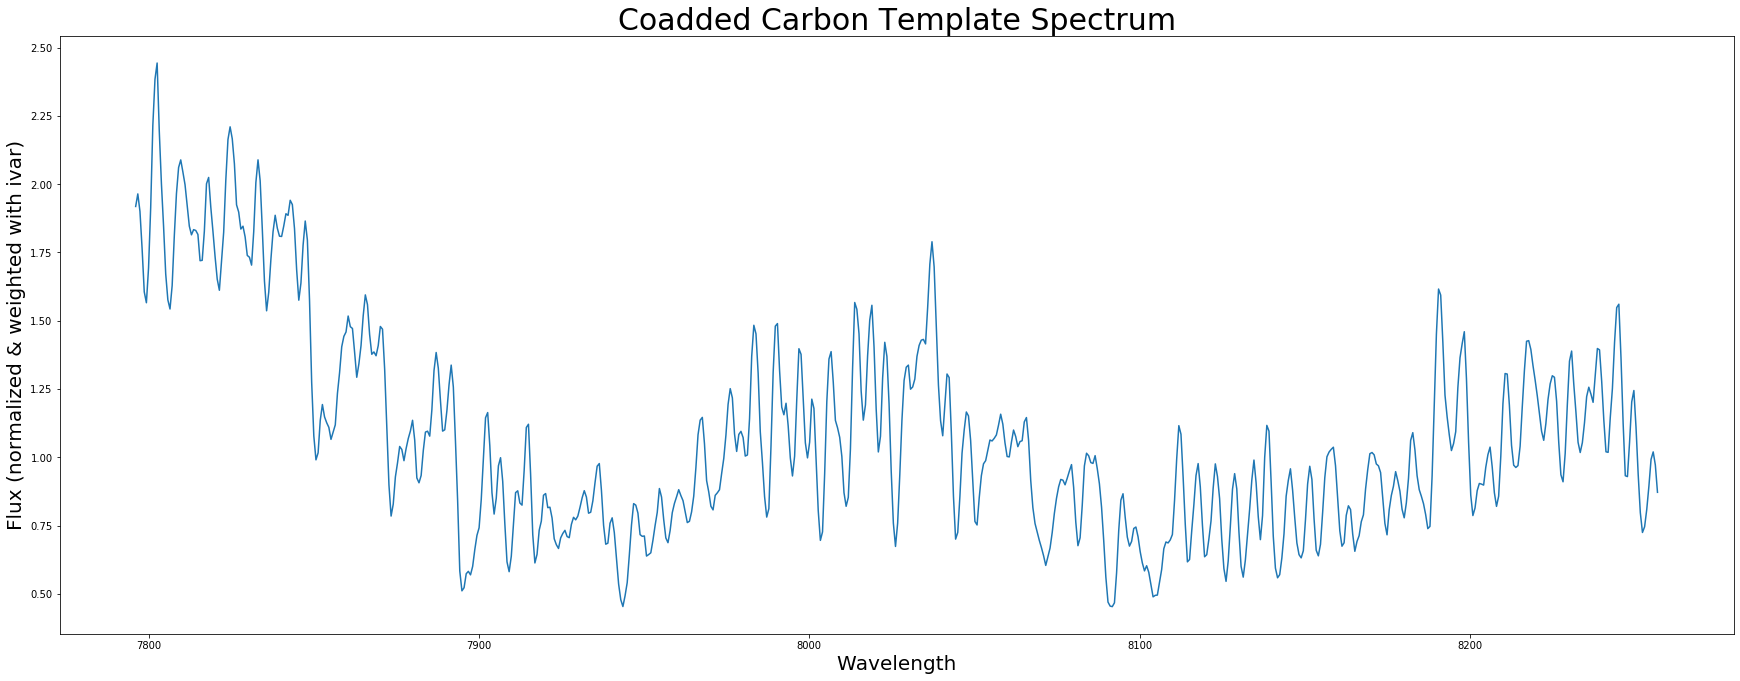

In [28]:
#graphs the limited-range carbon template spectrum created from the above function

x = Ctemplate_wv.tolist()
y = Ctemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Carbon Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()

## Ivar Analysis (Plotting & Trimming)
Focuses on analyzing ivars of different stars in order to further process and analyze spectral data. First, creates plots of ivar vs brightness to look for correlation between high ivar and high brightness (as a measure of affirmation that high ivar values are not unfounded). Then, trims the PHAT keckPhotoOthers sample set to match weak CN and carbon in terms of normalized distribution of ivars.
End result is two samples of others stars, others1 and others2, which match the weak CN and carbon ivar distributions, respectively.

### Part 1: Ivar v. Brightness Analysis

In [29]:
#creates the data needed to make a scatter plot of IVAR v MAGNITUDE 
#goal: check if extremely high ivar is really correct
#implementation note: can't use the ivarMeds lists because need to know the star itself (to determine the brightness)
x, y, wNm_x, wNm_y, carb_x, carb_y, kphO_x, kphO_y = [], [], [], [], [], [], [], [] #creating lists that will be filled with the coordinates for each star
highIvarNaN = wNmIvarNaN = carbIvarNaN = kphOIvarNaN  = 0 #defining counters that will be used to keep track of how many stars have NaN values in the F814W dataset
SAMPLE_OTHERS = False #this boolean represents a flag of whether to plot the full photo others (False), or only a 10% sample (True)
REMOVE_OVERLAP = True #this boolean represents a flag of whether to remove the high star data from the control data (since that is where they originate from, really)
                      #if REMOVE_OVERLAP is true, then the stars in the wNm, carbon, and kphOthers control groups will NOT have the highIvarStars data in them

print("Flag states:", "SAMPLE_OTHERS =", SAMPLE_OTHERS, 'and', "REMOVE_OVERLAP =", REMOVE_OVERLAP)
#create the x and y data for the high ivar stars: x = median of ivars, y = F814W magnitude
for star in highIvarStars:
    x.append(np.nanmedian(splashIvars_dict[star])) #these stars MUST have non-0, non-NaN ivars, due to their construction as "high ivar stars"
    y.append(data["F814W"][star])
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of highIvar
        highIvarNaN += 1
        
print('The following stars overlap in wNm and highIvarStars.') 
wNmOverlap = 0
for star in wNm: #control group 1: weak CN stars
    if star not in wNm_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        med = wNm_ivarMeds_dict[star]
        wNm_x.append(med) #if REMOVE_OVERLAP is False, this will be the same as wNm_ivarMeds; otherwise, it is no-highIvarStar clipped version
        wNm_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        print(star, "median ivar =", med)
        wNmOverlap += 1
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of wNm
        wNmIvarNaN += 1
if wNmOverlap == 0:
    print("NONE")
        

print('The following stars overlap in carbon and highIvarStars.')
cOverlap = 0
for star in allcarbon: #control group 2: carbon stars
    if star not in carbon_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        med = carbon_ivarMeds_dict[star]
        carb_x.append(med) #if REMOVE_OVERLAP is False, this will be the same as carbon_ivarMeds; otherwise, it is no-highIvarStar clipped version
        carb_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        cOverlap += 1
        print(star, "median ivar =", med)
    if np.isnan(data["F814W"][star]): #gathering metadata on cardinality of brightness-NaN-subset of carbon
        carbIvarNaN += 1
if cOverlap == 0:
    print("NONE")

print('The following stars overlap in the control group of PHAT-others and highIvarStars.')
oOverlap = 0
if SAMPLE_OTHERS:
    picker = 0
    print('SAMPLE_OTHERS = TRUE, so this is not ALL of the stars in highIvarStars from keckPhotoOthers; since this is a 10% sample, it is likely 10% the actual, larger number.')
for star in keckPhotoOthers: #control group 3: keckPhotoOthers (with possibility of randomized 10% subset)
    if SAMPLE_OTHERS:
        picker += 1
        if not picker % 10 == randrange(0, 9, 1): #generates a random number to use, will pick ~1/10 the subset
            continue
    if star not in kphOthers_ivarMeds_dict: #ensures that stars whose spectra could not be normalized are skipped over
        continue
    currentMed = kphOthers_ivarMeds_dict[star]
    if not REMOVE_OVERLAP or (REMOVE_OVERLAP and star not in highIvarStars):
        kphO_x.append(currentMed)
        kphO_y.append(data["F814W"][star])
    if star in highIvarStars: #gathering metadata on the stats of high-IVAR stars and their distribution in SPLASH
        print(star, "median ivar =", currentMed)
        oOverlap += 1
    if np.isnan(data["F814W"][star]):
        kphOIvarNaN += 1 #this will likely be 0 (although not certain, due to "OR" condition in keckPhotoOthers construction)
if oOverlap == 0:
    print("NONE")
    
#printing out metadata for debugging/testing uses        
print("Brightness NaN counts (highIvar, wNm, carbon, kphO):", highIvarNaN, wNmIvarNaN, carbIvarNaN, kphOIvarNaN) #check to see how many of each type don't have data in F814W 
print("Total Stars (highIvar, wNm, carbon, kphO):", len(x), len(wNm_y), len(carb_y), len(kphO_y))
print("Overlaps (wNm, carbon, kphO):", wNmOverlap, cOverlap, oOverlap)
print("Maximum Ivar Found:", np.max(x))

Flag states: SAMPLE_OTHERS = False and REMOVE_OVERLAP = True
The following stars overlap in wNm and highIvarStars.
20903 median ivar = 262.89997553928066
21555 median ivar = 110.2616634990361
24483 median ivar = 93.30942519182388
24926 median ivar = 138.34087599596683
20291 median ivar = 604.6909361239703
20320 median ivar = 486.30066856688643
21069 median ivar = 19.51136386467212
21305 median ivar = 185.83203399376632
21308 median ivar = 185.83203399376632
21323 median ivar = 185.83203399376632
21474 median ivar = 135.62499996532108
21588 median ivar = 250.98972966615247
21729 median ivar = 69.82537781146353
21821 median ivar = 69.82537781146353
21858 median ivar = 69.82537781146353
22009 median ivar = 178.11910531903385
22569 median ivar = 150.37443675864526
22602 median ivar = 167.72658420556075
23596 median ivar = 98.45840943921644
23693 median ivar = 336.6515339933757
24045 median ivar = 126.41405848443782
24233 median ivar = 336.5530303142299
The following stars overlap in carbon

### Part 3: Trimming Based on Ivars

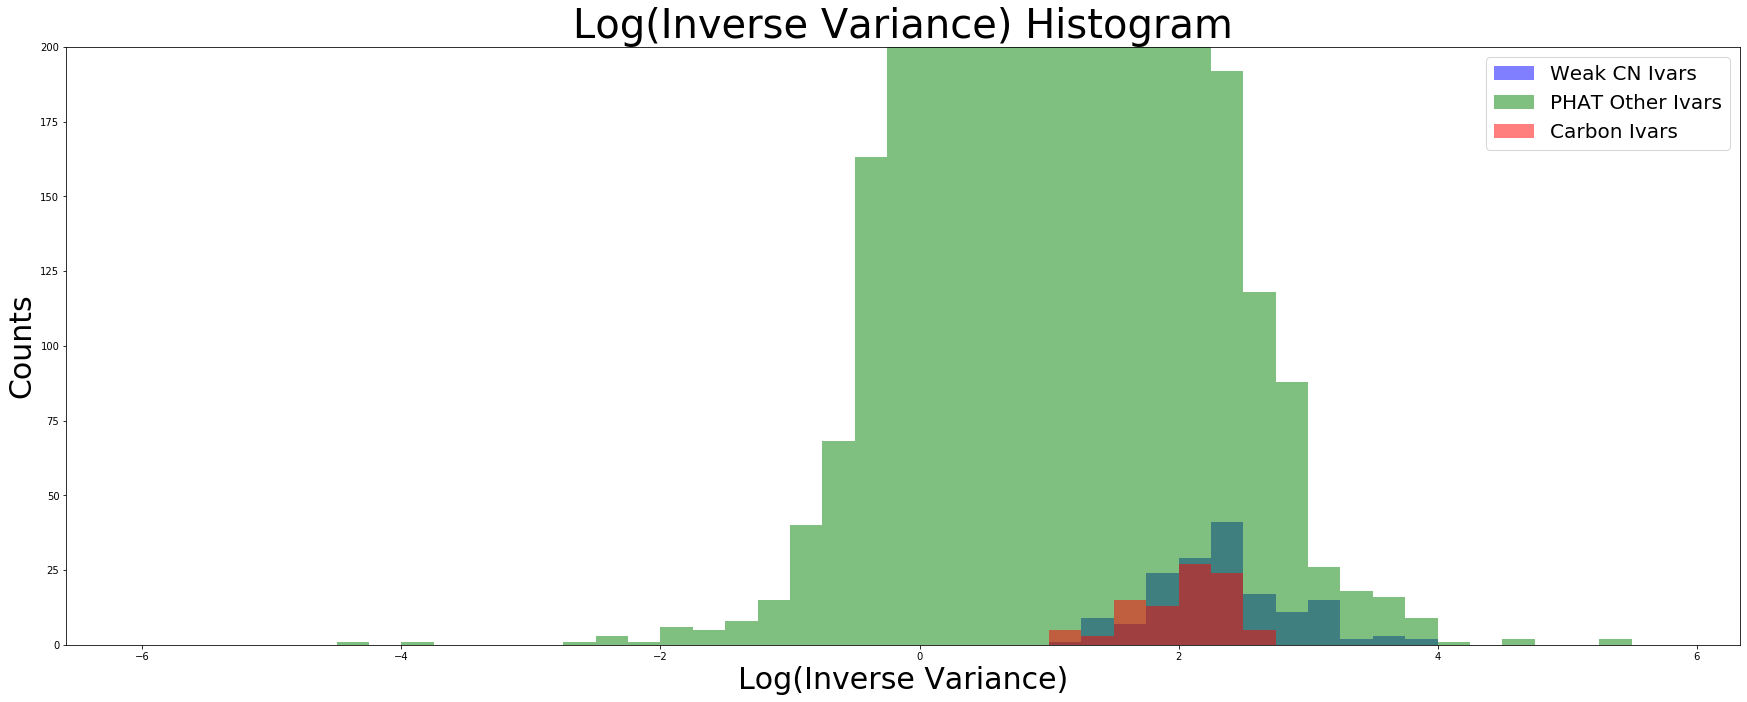

In [30]:
#method of ivar trimming: take a ratio based on high-ivar ratio
#step 1: create histogram based on log (ivar), step sizes of 1.5
binList = np.arange(-6, 6, 0.25) #largest value ~160000

wNm_logHighData = plt.hist(np.log(wNm_ivarMeds)/np.log(10), bins = binList, color = "b", alpha = 0.5, label = "Weak CN Ivars")
kphO_logHighData = plt.hist(np.log(kphOthers_ivarMeds)/np.log(10), bins = binList, color = "g", alpha = 0.5, label = "PHAT Other Ivars")
carb_logHighData = plt.hist(np.log(carbon_ivarMeds)/np.log(10), bins = binList, color = "r", alpha = 0.5, label = "Carbon Ivars")
plt.legend(fontsize = 20)
plt.title("Log(Inverse Variance) Histogram", fontsize = 40)
plt.xlabel("Log(Inverse Variance)", fontsize = 30)
plt.ylabel("Counts", fontsize = 30)
plt.ylim(0, 200)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams['figure.figsize'] = 30, 11
#plt.savefig('logivar_histbase.png')
plt.show()

In [31]:
#step 2: find ratios of other stars to wNm and carbon stars at high ivars, which will be applied to lower ivars to clip the sample
#finding ratio for others1 (high kphOthers:high wNm)
#note: bucket with high-ivar values (log IVAR_LIMIT = log 1000 = 3) is index 36
highKphOSum = highwNmSum = 0
for i in range(36, len(kphO_logHighData[0])):
    highKphOSum += kphO_logHighData[0][i]
    highwNmSum += wNm_logHighData[0][i]
others1R = highKphOSum/highwNmSum

#finding ratio for others2 (kphOthers:carbon) after 10^2.5 (~316)
#note: bucket with high-ivar values (log IVAR_LIMIT = log 10^2.5 = 2.5) is index 34
highKphOSum = highCarbSum = 0
for i in range(34, len(kphO_logHighData[0])):
    if not carb_logHighData[0][i] == 0: #stops the ratio from going beyond 700-ish, as the carbon stars are limited by that value but the other stars are not
        highKphOSum += kphO_logHighData[0][i]
        highCarbSum += carb_logHighData[0][i]
others2R = highKphOSum/highCarbSum

print('others1:', others1R, '|', 'others2:', others2R)

others1: 3.3636363636363638 | others2: 23.6


In [32]:
#creating trimmed others1 and others2 samples based on the ivar-trimming functions above
chosenStars1, kphTrimmedOthers1_ivarMeds = trimStars(keckPhotoOthers, kphOthers_ivarMeds_dict, wNm_logHighData, others1R, kphO_logHighData)
kphTrimmedOthers1 = np.array(keckPhotoOthers)[chosenStars1]
chosenStars2, kphTrimmedOthers2_ivarMeds = trimStars(keckPhotoOthers, kphOthers_ivarMeds_dict, carb_logHighData, others2R, kphO_logHighData)
kphTrimmedOthers2 = np.array(keckPhotoOthers)[chosenStars2]

### Part 5: Further Cleaning of Others2 Data
Goal: to make the others2 sample better match the carbon star sample in terms of ivar distribution. Current methods: don't keep any stars with ivar > 700, from 0 - 100 keep only 30% of stars (evenly distributed in range after sorting; i.e. 1, 5, 9 in every interval of 10), and from 450 - 700 keep only 10% of stars (after sorting, only star 4 in every interval of 10).

In [33]:
#performs the clean-up of the others2 sample based on the methods described above
keep = []
keepIvars = []
UPPER_LIM = 700 #no carbon stars have median ivars beyond 700

kphTrimmed2_dict = {}
for star in kphTrimmedOthers2:
    kphTrimmed2_dict[star] = kphOthers_ivarMeds_dict[star] #all stars in kphTrimmedOthers2 are in ivarMeds dictionary, but not vice versa

ctr = 1
for star in sorted(kphTrimmed2_dict, key = kphTrimmed2_dict.get):
    ctr = ctr % 10
    keepStar = True
    if star not in kphOthers_ivarMeds_dict:
        continue
    med = kphOthers_ivarMeds_dict[star]
    if med > UPPER_LIM: 
        keepStar = False
    if 0 < med < 100: 
        if ctr % 2 == 0 or ctr == 3 or ctr == 7: #a way of picking 1, 5, 9 values
            keepStar = False
    if 450 <= med < 700:
        if not ctr == 4:
            keepStar = False
    ctr += 1
    if keepStar:
        keep.append(star)
        keepIvars.append(kphTrimmed2_dict[star])

#creates the final trimmed-by-ivar others2 sample, with separate but corresponding median ivars
kphTrimmedOthers2, kphTrimmedOthers2_ivarMeds = keep, keepIvars

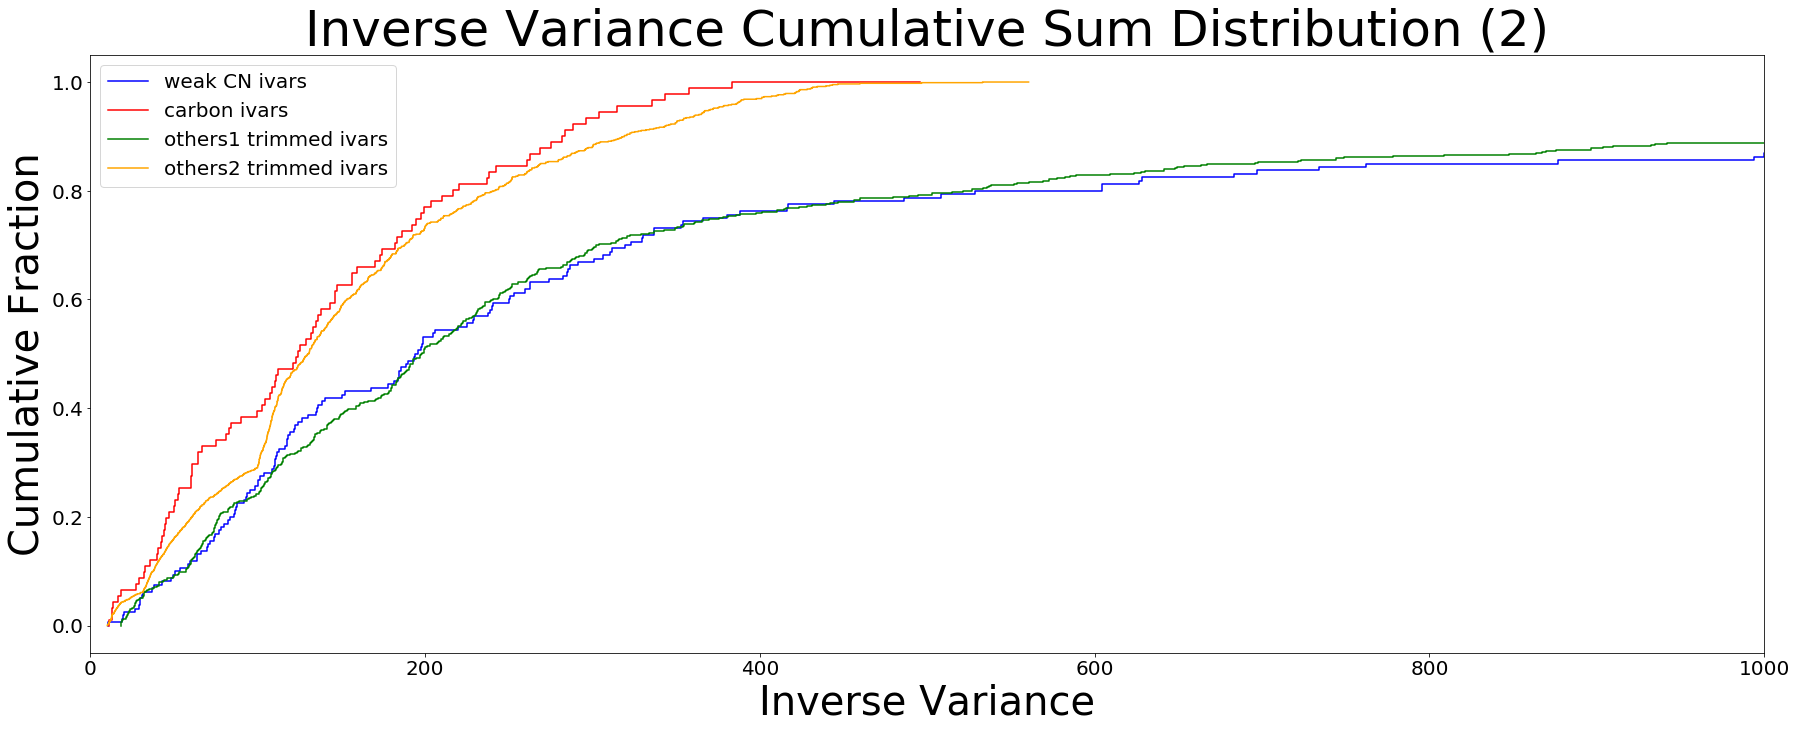

In [34]:
#making unbinned cumulative distribution plots, based on a step of 1/N for each data point
#step 1: sorting the data
wNm_sortedMeds = np.sort(wNm_ivarMeds)
carb_sortedMeds = np.sort(carbon_ivarMeds)
kphO1_sortedMeds = np.sort(kphTrimmedOthers1_ivarMeds)
kphO2select_sortedMeds = np.sort(np.array(kphTrimmedOthers2_ivarMeds))


#step 2: make the cumulative sum as a step function with a step size of 1 / N (where N is set size), so all samples' y's end at 1
plt.step(wNm_sortedMeds, np.linspace(0, 1, len(wNm_sortedMeds)), color = 'blue', label = "weak CN ivars")
plt.step(carb_sortedMeds, np.linspace(0, 1, len(carb_sortedMeds)),  color = 'red', label = "carbon ivars")
plt.step(kphO1_sortedMeds,np.linspace(0, 1, len(kphO1_sortedMeds)), color = 'green', label = "others1 trimmed ivars")
plt.step(kphO2select_sortedMeds,np.linspace(0, 1, len(kphO2select_sortedMeds)), color = 'orange', label = "others2 trimmed ivars")

#formatting the chart so that it is easy to read
plt.title("Inverse Variance Cumulative Sum Distribution (2)", size = 50) 
plt.xlabel("Inverse Variance", size = 40)
plt.ylabel("Cumulative Fraction", size = 40)
plt.legend(fontsize = 20)
plt.xlim(0, 1000)
plt.rcParams['figure.figsize'] = 30, 11
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
#plt.savefig('ivarDistr_cumulativeSum_others1+2_shaped_final.png')
plt.show()

# --------------------------------------------------
# WEIGHTED DIST ANALYSIS

## Calculating distances from Comet Plot

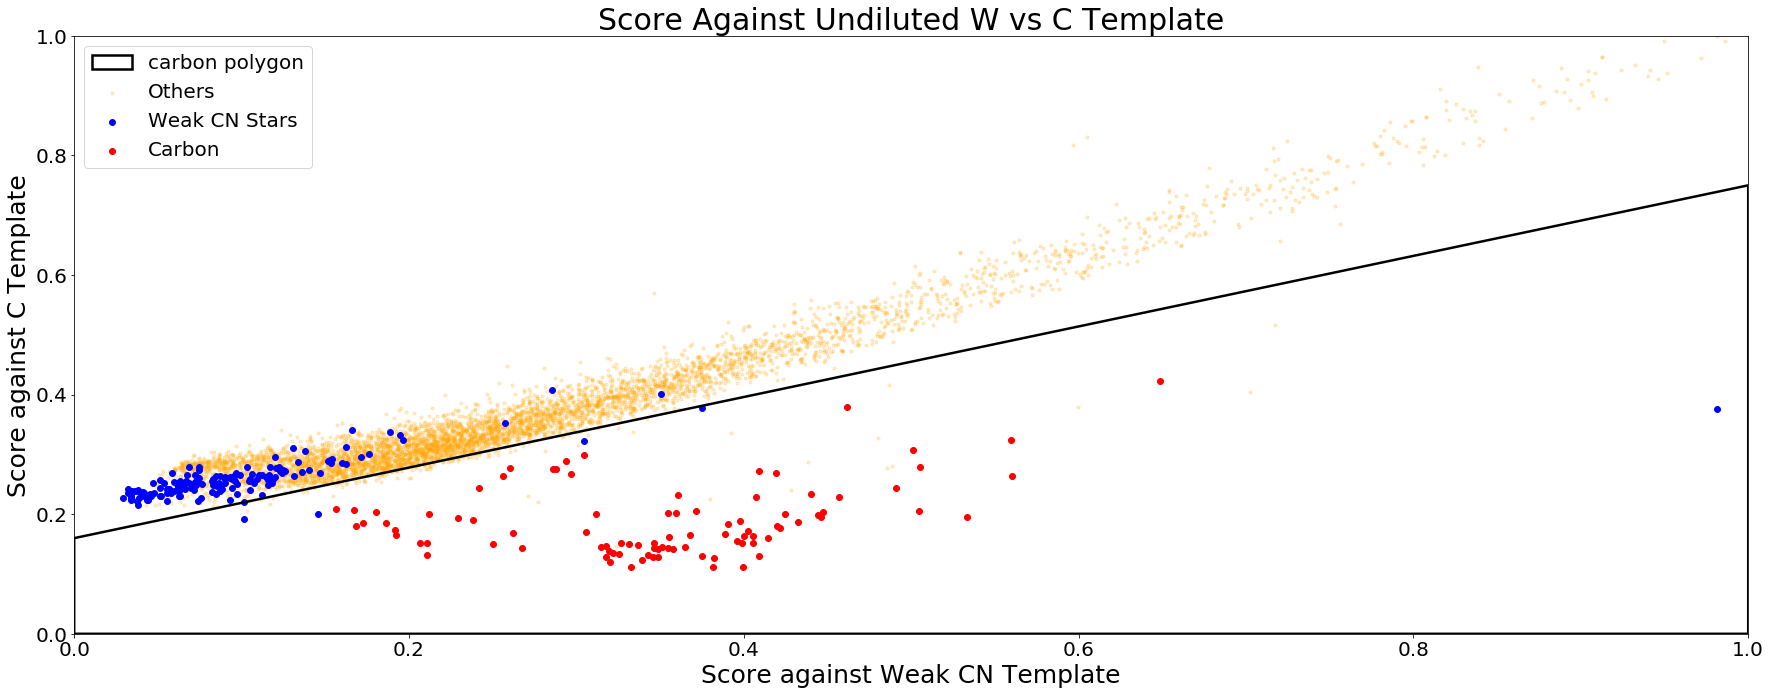

In [35]:
#using only stars that has keckphat data
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')
plt.scatter(dicts['kphOthers_score2_uwdict'].values(),dicts['kphOthers_score2_ucdict'].values(), color ='orange', alpha =0.2, s= 10, label = 'Others')
plt.scatter(dicts['wNm_score2_uwdict'].values(),dicts['wNm_score2_ucdict'].values(), color='blue',s=35, label = 'Weak CN Stars')
plt.scatter(dicts['carbon_score2_uwdict'].values(),dicts['carbon_score2_ucdict'].values(), color ='red', label = 'Carbon')

#carbon line
carbon_polygon =[[0,0.16],[1,0.75],[1,0],[0,0]]
polygon(carbon_polygon, 'black',label='carbon polygon')

plt.rcParams['figure.figsize'] = 30,11 
# plt.xlim([0,0.25])
# plt.ylim([0.1,0.4])
plt.xlim(0,1)
plt.ylim(0,1)

plt.xlabel("Score against Weak CN Template", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Undiluted W vs C Template", size = 30) 
plt.legend(fontsize = 20)
plt.show()
# print(len(kphOthers_score2_uwdict))

In [37]:
import math  
from scipy.spatial.distance import cdist

#create arrays for the comet plot x,y values
kphothers_x = np.array(list(dicts['kphOthers_score2_uwdict'].values()))
kphothers_y = np.array(list(dicts['kphOthers_score2_ucdict'].values()))
wnm_x = np.array(list(dicts['wNm_score2_uwdict'].values()))
wnm_y = np.array(list(dicts['wNm_score2_ucdict'].values()))

#combine x,y values into 2d array
kphothers_coord = np.vstack((kphothers_x, kphothers_y)).T
wnm_coord = np.vstack((wnm_x, wnm_y)).T

#set up arbitrary reference coordinate - the end of the comet plot
x = np.array(0.03)
y =np.array(0.23) 

reference_coord = np.vstack((x,y)).T

#calculate distances between reference point and coordinates of stars
#result saved in an array
kphothers_dist = cdist(reference_coord,kphothers_coord)
wnm_dist = cdist(reference_coord,wnm_coord)

#combine into one array of wnm and other stars
kphothers_wnm_dist = np.concatenate((kphothers_dist, wnm_dist), axis= None)

#confirm length of arrays
print(kphothers_dist.size)
print(wnm_dist.size)
print(kphothers_wnm_dist.size)

#was tested and confirmed that distances are correct

5586
161
5747


In [38]:
len(wNm)

161

In [39]:
len(wnm_x)

161

### Calculating weight

In [40]:
from math import exp

#calculating exponential formula to weight point size on plots

#max and min point size based on max and min distance
#rachel- or we can choose aribitrary values
p_max = 100
p_min = 10

#free parameter D_0 can be used to control the distribution of point sizes
D_0 = 0.075

'''
D is the distance from the comet head
A small value of D_0 (say 0.5 or less) will result in
only a few large points and most of the points will be small. 
A large value of D_0 (say 5) will result in most points being large.
'''

weight_kphothers_wnm = []
weight_kphothers =[]
weight_wnm=[]

for D in np.nditer(kphothers_wnm_dist):
    weight1 = (p_max - p_min)* exp(- D/D_0) + p_min
    weight_kphothers_wnm.append(weight1)
    
for D in np.nditer(kphothers_dist):
    weight1 = (p_max - p_min)* exp(- D/D_0) + p_min
    weight_kphothers.append(weight1)

    
for D in np.nditer(wnm_dist):
    weight1 = (p_max - p_min)* exp(- D/D_0) + p_min
    weight_wnm.append(weight1)
    
    #need to check and confirm calculations for each weight array

In [41]:
#combine others and wnm to plot on cmd -should probably use kph others

kphothers_wnm = np.concatenate((keckPhotoOthers, wNm), axis= None)
#removed 20867 temporarily until we can rerun notebook

In [42]:
#create dictionary of star indice and weight
#checked if star with corresponding weight
keys = kphothers_wnm

weight_kphothers_wnm_dict = dict(zip(keys, np.asarray(weight_kphothers_wnm).T))


In [43]:
# for key, value in dict['kphOthers_score2_ucdict'].items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
#     if key == 21055:
#         print(value)
# # weight_kphothers_wnm_dict[21055]

In [44]:
print(len(weight_kphothers_wnm))
print(len(weight_kphothers))
print(len(weight_wnm))

5747
5586
161


## Slopes plot

In [45]:
#create slope arrays from dictionary values for weak CN
s4_wNm = np.array(list(dicts['wNm_s4_dict'].values()))
s3_wNm = np.array(list(dicts['wNm_s3_dict'].values()))
s2_wNm = np.array(list(dicts['wNm_s2_dict'].values()))
s1_wNm = np.array(list(dicts['wNm_s1_dict'].values()))

#create slope arrays from dictionary values for Carbon
s4_C = np.array(list(dicts['carbon_s4_dict'].values()))
s3_C = np.array(list(dicts['carbon_s3_dict'].values()))
s2_C = np.array(list(dicts['carbon_s2_dict'].values()))
s1_C = np.array(list(dicts['carbon_s1_dict'].values()))

#create slope arrays from dictionary values for Others
s4_O = np.array(list(dicts['others_s4_dict'].values()))
s3_O = np.array(list(dicts['others_s3_dict'].values()))
s2_O = np.array(list(dicts['others_s2_dict'].values()))
s1_O = np.array(list(dicts['others_s1_dict'].values()))

#create slope arrays from dictionary values for kphOthers
s4_kphO = np.array(list(dicts['kphOthers_s4_dict'].values()))
s3_kphO = np.array(list(dicts['kphOthers_s3_dict'].values()))
s2_kphO = np.array(list(dicts['kphOthers_s2_dict'].values()))
s1_kphO = np.array(list(dicts['kphOthers_s1_dict'].values()))

#Perform s4-s3 and s2-s1 operation for each group
s4_s3_wNm = s4_wNm - s3_wNm
s2_s1_wNm = s2_wNm - s1_wNm

s4_s3_C = s4_C - s3_C
s2_s1_C = s2_C - s1_C

s4_s3_O = s4_O - s3_O
s2_s1_O = s2_O - s1_O

s4_s3_kphO = s4_kphO - s3_kphO
s2_s1_kphO = s2_kphO - s1_kphO

#Normalize s4-s3 and s2-s1 to template


In [46]:
#combine slope differences for kphothers and wnm
s4_s3_kphO_wnm = np.concatenate((s4_s3_kphO, s4_s3_wNm), axis= None)
s2_s1_kphO_wnm = np.concatenate((s2_s1_kphO, s2_s1_wNm), axis= None)


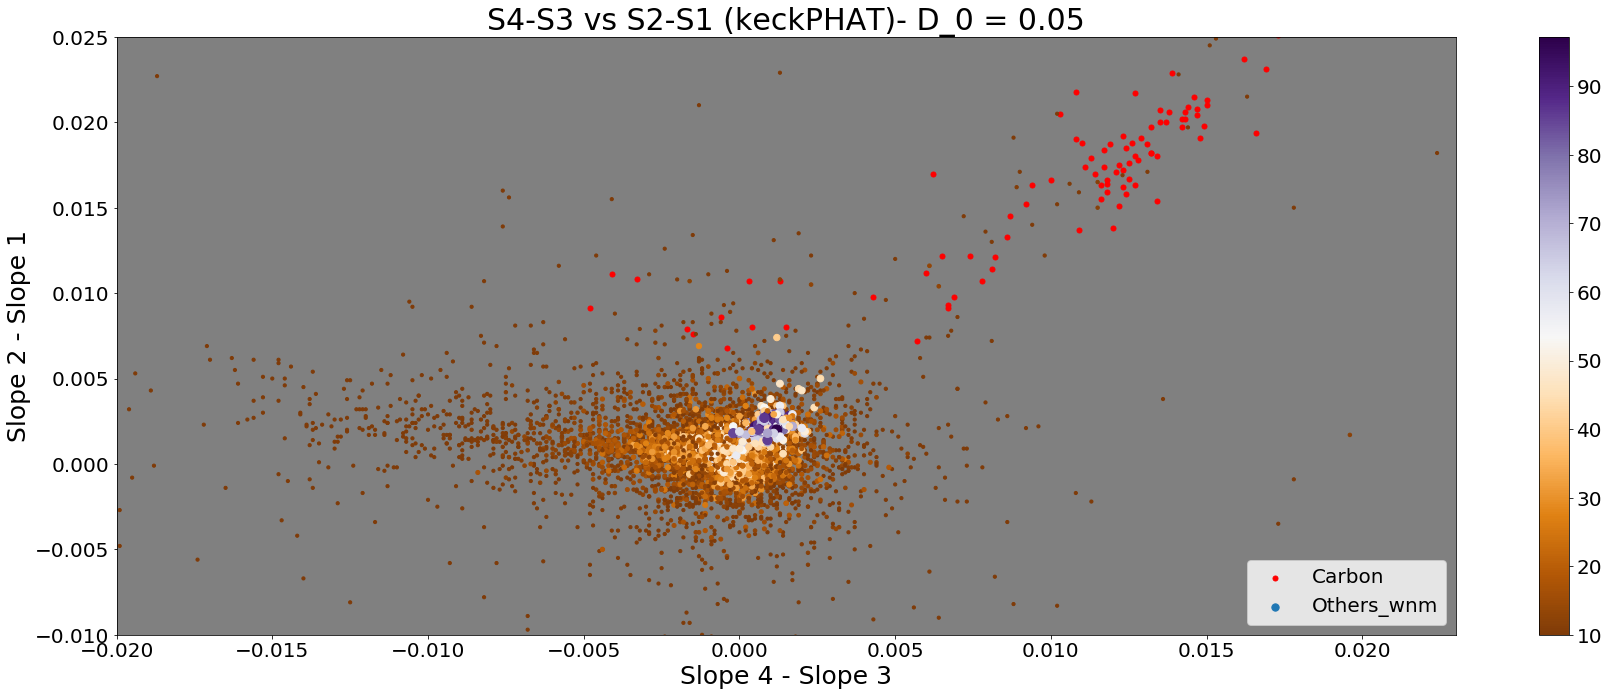

In [47]:
#s4-s3 vs s2-s1 with polygon
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('grey')

plt.scatter(s4_s3_C, s2_s1_C, color ='red',s=25, label = 'Carbon')
plt.scatter(s4_s3_kphO_wnm, s2_s1_kphO_wnm, alpha =1,c=weight_kphothers_wnm, s= weight_kphothers_wnm, cmap='PuOr',label = 'Others_wnm')
plt.rcParams['figure.figsize'] = 30,11 
plt.title("S4-S3 vs S2-S1 (keckPHAT)- D_0 = 0.05", size = 30) 
plt.ylabel("Slope 2 - Slope 1", size = 25)
plt.xlim([-.02,.023])
plt.ylim([-.01,.025])
# plt.xlim([-0.005,0.003])
# plt.ylim([-0.005,0.008])
plt.xlabel("Slope 4 - Slope 3", size = 25)
plt.legend(fontsize = 20)
plt.colorbar()
plt.show()

## DF Plot

In [48]:
#combine kphothers and wnm dicts to plot df plot
kphothers_wnm_df ={}
kphothers_wnm_df.update(dicts['kphOthers_c_dict'])
kphothers_wnm_df.update(dicts['wNm_c_dict'])

kphothers_wnm_cscore ={}
kphothers_wnm_cscore.update(dicts['kphOthers_score2_dict'])
kphothers_wnm_cscore.update(dicts['wNm_score2_dict'])


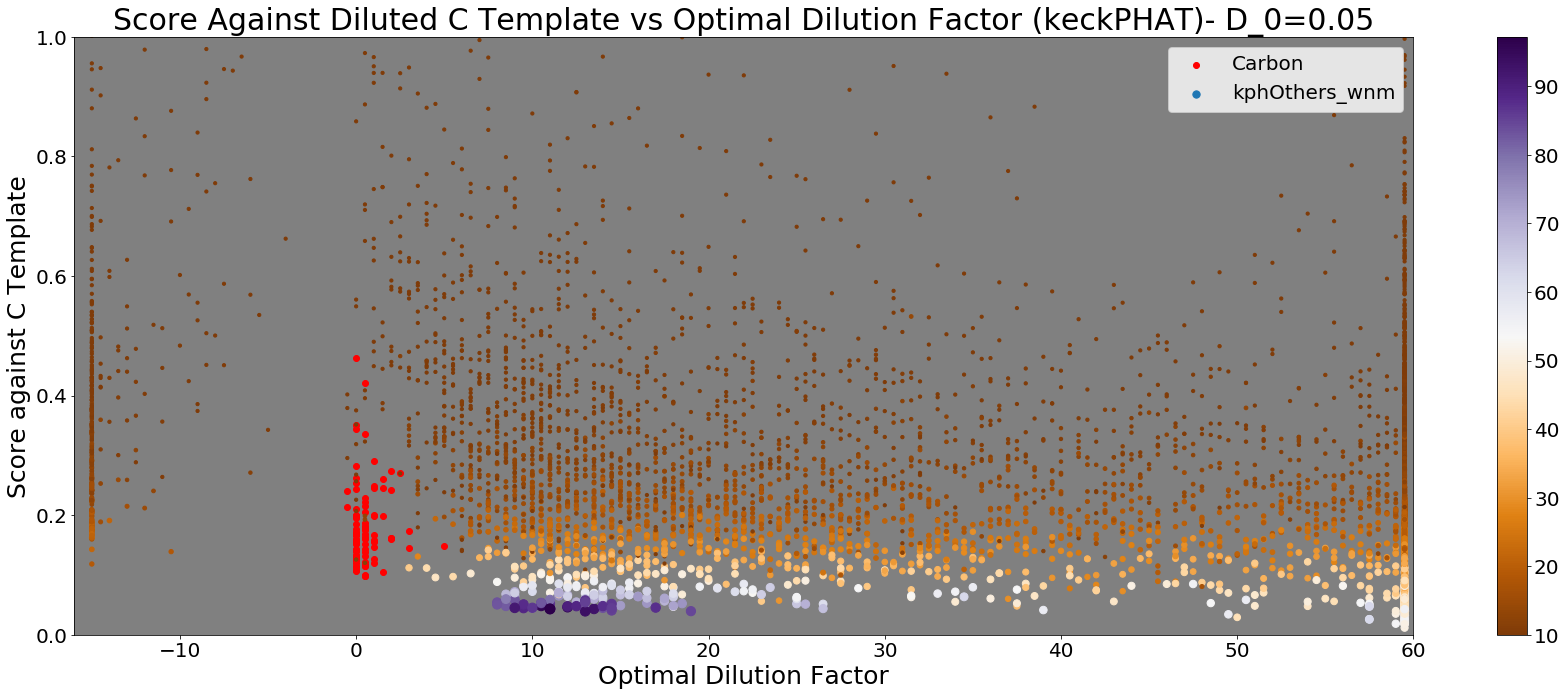

In [49]:
#weighted plot with cmap
plt.rcParams['figure.figsize'] = 30,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('grey')
plt.scatter(dicts['carbon_c_dict'].values(),dicts['carbon_score2_dict'].values(), color ='red', label = 'Carbon')
plt.scatter(kphothers_wnm_df.values(),kphothers_wnm_cscore.values(),c=weight_kphothers_wnm,  alpha =1, s=weight_kphothers_wnm,cmap='PuOr',label = 'kphOthers_wnm')
plt.xlim([-16,60])
plt.ylim([0,1])
plt.xlabel("Optimal Dilution Factor", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Diluted C Template vs Optimal Dilution Factor (keckPHAT)- D_0=0.05", size = 30)
plt.legend(fontsize = 20)
plt.colorbar()
plt.show()

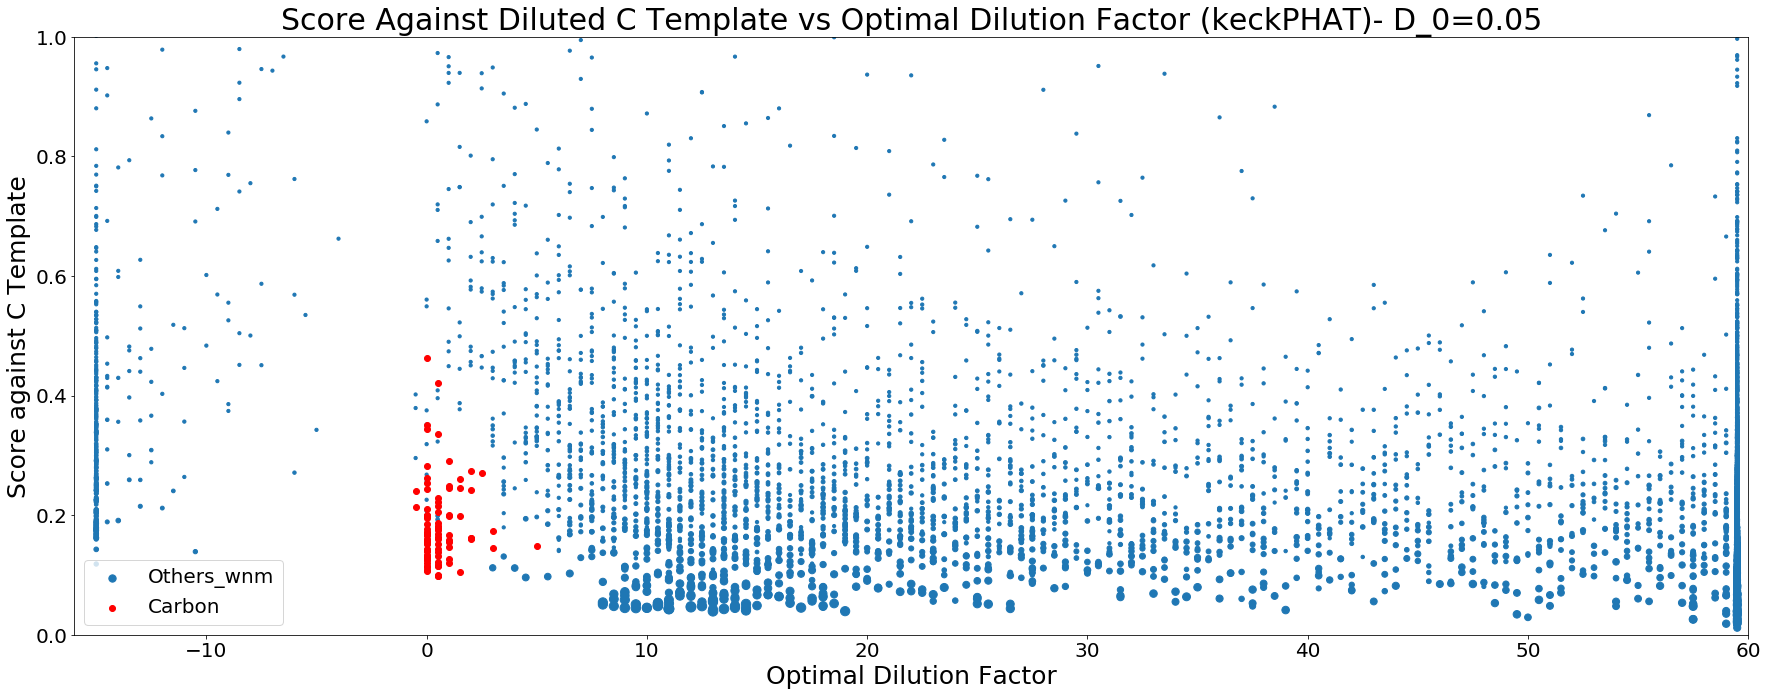

In [50]:
#weighted plot no cmap
plt.rcParams['figure.figsize'] = 30,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')
plt.scatter(kphothers_wnm_df.values(),kphothers_wnm_cscore.values(),  alpha =1, s=weight_kphothers_wnm,label = 'Others_wnm')

plt.scatter(dicts['carbon_c_dict'].values(),dicts['carbon_score2_dict'].values(), color ='red', label = 'Carbon')
plt.xlim([-16,60])
plt.ylim([0,1])
plt.xlabel("Optimal Dilution Factor", size = 25)
plt.ylabel("Score against C Template", size = 25)
plt.title("Score Against Diluted C Template vs Optimal Dilution Factor (keckPHAT)- D_0=0.05", size = 30)
plt.legend(fontsize = 20)

plt.show()

## CMD

### F814W-F160W vs F160W

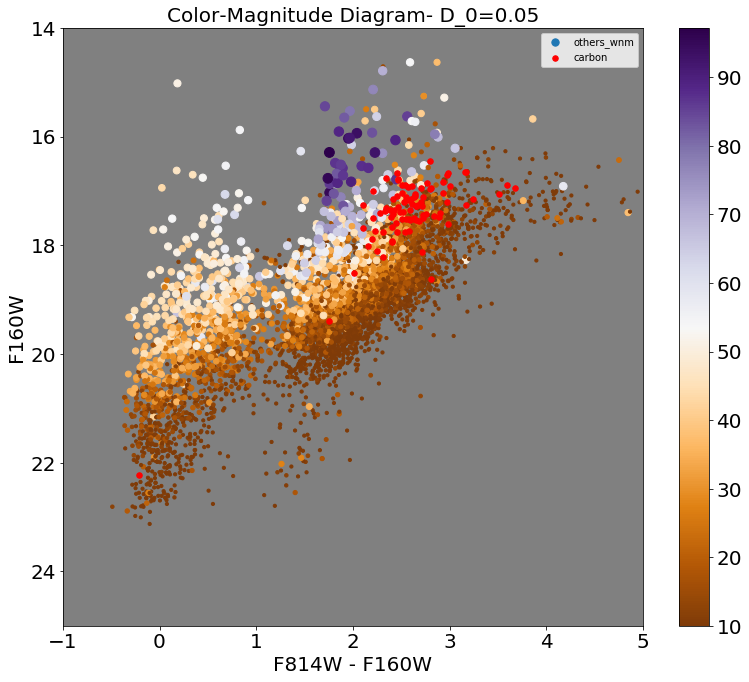

In [51]:
plt.rcParams['figure.figsize'] = 13,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('grey')

plt.scatter((data.F814W[kphothers_wnm] - data.F160W[kphothers_wnm]), data.F160W[kphothers_wnm], c=weight_kphothers_wnm,s = weight_kphothers_wnm, cmap='PuOr', label = 'others_wnm', facecolors = 'none')
plt.colorbar()
plt.scatter((data.F814W[allcarbon] - data.F160W[allcarbon]), data.F160W[allcarbon], s = 30, color = 'red', label = 'carbon')

plt.title("Color-Magnitude Diagram- D_0=0.05", size = 20) 
plt.ylabel("F160W", size = 20)
plt.xlabel("F814W - F160W", size = 20)
plt.xlim(-1, 5)
plt.ylim(25, 14)
# plt.xlim(1,4)
# plt.ylim(21,16)
plt.legend(loc = "upper right")

plt.show()

###  F336W–F475W vs F475W 

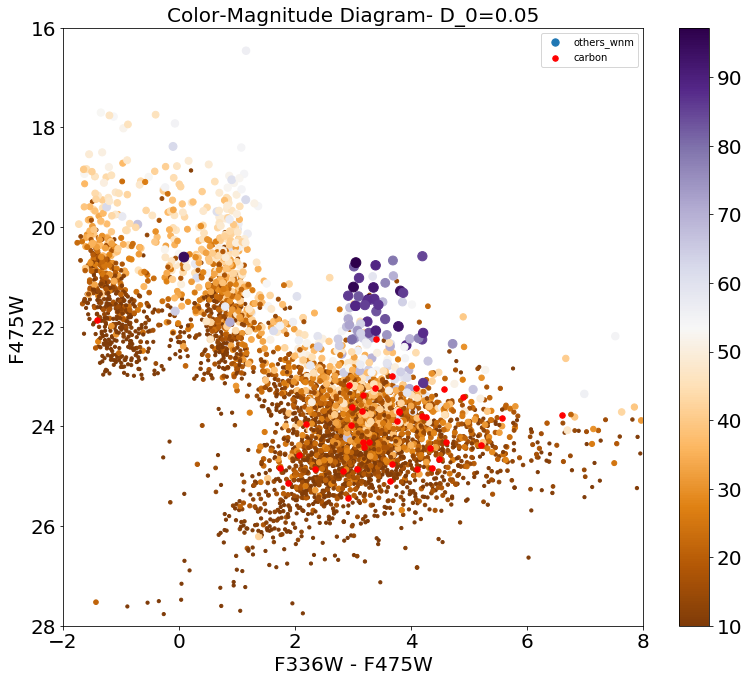

In [52]:
#creates the CMD with our bins
plt.rcParams['figure.figsize'] = 13,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')

plt.scatter((data.F336W[kphothers_wnm] - data.F475W[kphothers_wnm]), data.F475W[kphothers_wnm], c=weight_kphothers_wnm,s = weight_kphothers_wnm, cmap='PuOr', label = 'others_wnm', facecolors = 'none')
plt.colorbar()
plt.scatter((data.F336W[allcarbon] - data.F475W[allcarbon]), data.F475W[allcarbon], s = 30, color = 'red', label = 'carbon')

#plt.plot(xRos, yRos, color = 'black', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

plt.title("Color-Magnitude Diagram- D_0=0.05", size = 20) 
plt.ylabel("F475W", size = 20)
plt.xlabel("F336W - F475W", size = 20)
plt.xlim(-2, 8)
plt.ylim(16, 28)
# plt.xlim(1,4)
# plt.ylim(21,16)
plt.gca().invert_yaxis()
plt.legend(loc = "upper right")

plt.show()

### F475W–F814W vs F814W 

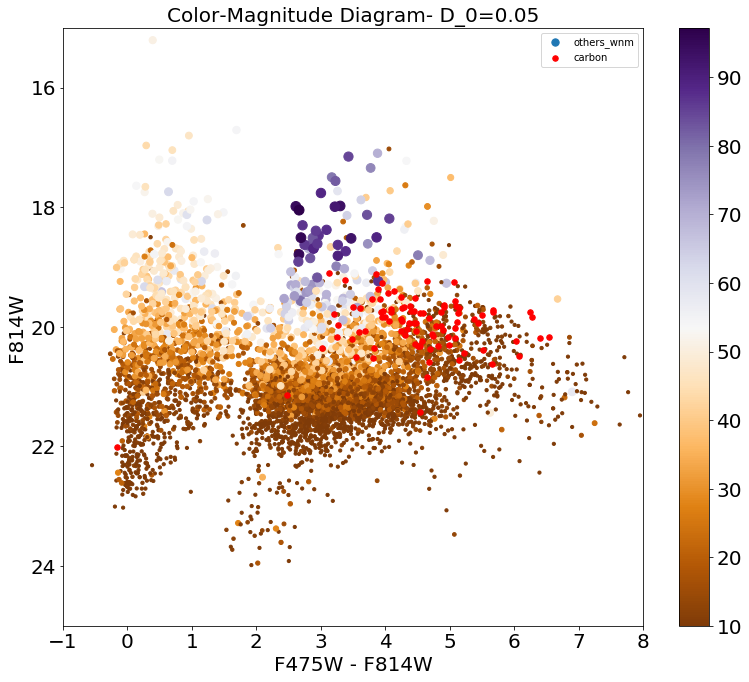

In [53]:
#creates the CMD with our bins
plt.rcParams['figure.figsize'] = 13,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')

plt.scatter((data.F475W[kphothers_wnm] - data.F814W[kphothers_wnm]), data.F814W[kphothers_wnm], c=weight_kphothers_wnm,s = weight_kphothers_wnm, cmap='PuOr', label = 'others_wnm', facecolors = 'none')
plt.colorbar()
plt.scatter((data.F475W[allcarbon] - data.F814W[allcarbon]), data.F814W[allcarbon], s = 30, color = 'red', label = 'carbon')

#plt.plot(xRos, yRos, color = 'black', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

plt.title("Color-Magnitude Diagram- D_0=0.05", size = 20) 
plt.ylabel("F814W", size = 20)
plt.xlabel("F475W - F814W", size = 20)
plt.xlim(-1, 8)
plt.ylim(15, 25)
# plt.xlim(1,4)
# plt.ylim(21,16)

plt.gca().invert_yaxis()
plt.legend(loc = "upper right")

plt.show()

###  F814W–F110W vs F110W 

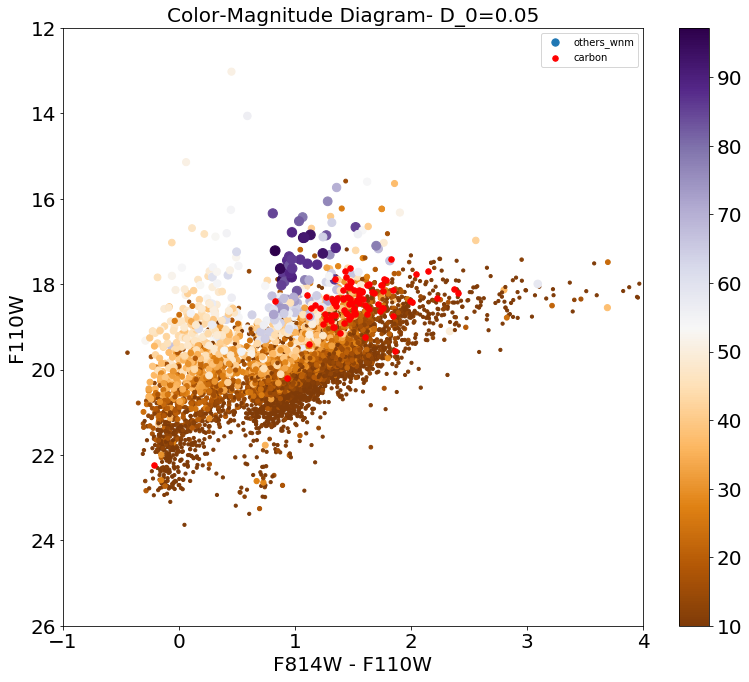

In [54]:
#creates the CMD with our bins
plt.rcParams['figure.figsize'] = 13,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')

plt.scatter((data.F814W[kphothers_wnm] - data.F110W[kphothers_wnm]), data.F110W[kphothers_wnm], c=weight_kphothers_wnm,s = weight_kphothers_wnm, cmap='PuOr', label = 'others_wnm', facecolors = 'none')
plt.colorbar()
plt.scatter((data.F814W[allcarbon] - data.F110W[allcarbon]), data.F110W[allcarbon], s = 30, color = 'red', label = 'carbon')

#plt.plot(xRos, yRos, color = 'black', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

plt.title("Color-Magnitude Diagram- D_0=0.05", size = 20) 
plt.ylabel("F110W", size = 20)
plt.xlabel("F814W - F110W", size = 20)
plt.xlim(-1, 4)
plt.ylim(12, 26)
# plt.xlim(1,4)
# plt.ylim(21,16)

plt.gca().invert_yaxis()
plt.legend(loc = "upper right")

plt.show()

### F110W–F160W vs F160W 

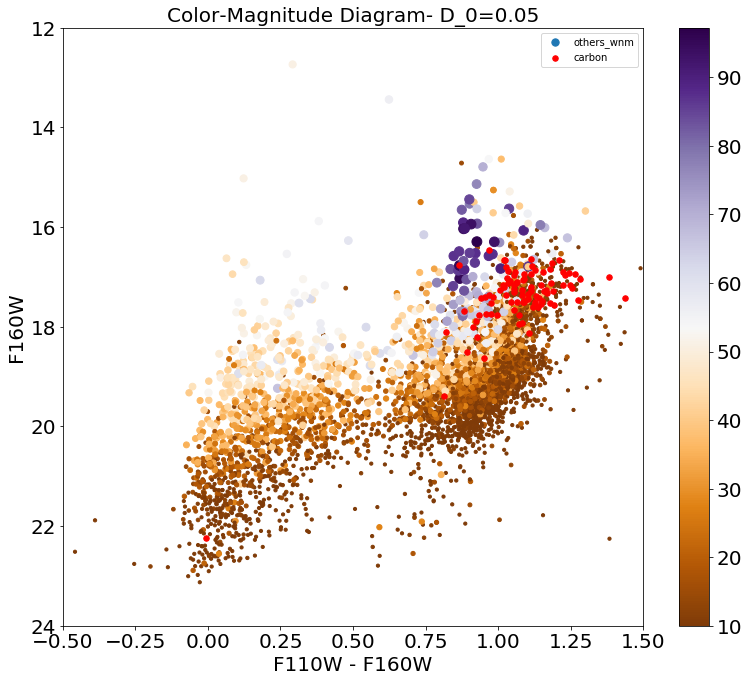

In [55]:
#creates the CMD with our bins
plt.rcParams['figure.figsize'] = 13,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')


plt.scatter((data.F110W[kphothers_wnm] - data.F160W[kphothers_wnm]), data.F160W[kphothers_wnm], c=weight_kphothers_wnm,s = weight_kphothers_wnm, cmap='PuOr', label = 'others_wnm', facecolors = 'none')
plt.colorbar()
plt.scatter((data.F110W[allcarbon] - data.F160W[allcarbon]), data.F160W[allcarbon], s = 30, color = 'red', label = 'carbon')

#plt.plot(xRos, yRos, color = 'black', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

plt.title("Color-Magnitude Diagram- D_0=0.05", size = 20) 
plt.ylabel("F160W", size = 20)
plt.xlabel("F110W - F160W", size = 20)
plt.xlim(-0.5, 1.5)
plt.ylim(12, 24)
# plt.xlim(1,4)
# plt.ylim(21,16)
plt.gca().invert_yaxis()
plt.legend(loc = "upper right")

plt.show()

## Coadding F336-475 vs 475

In [56]:
#defines variables that will be used for graphing Rosenfield's line
m = (19 - -52.965)/(2.03045-10)
xRos = np.arange(1, 3, .01)
yRos = m*xRos - 2.0345*m + 19

In [57]:
#defines lists of points to be used as the vertices of CMD bin polygons

#polygon points for bottom-right,bottom-left,top-left,top-right
bin1 = [[-0.25, 23.25],[-1.9, 23.25],[-1.9, 17.5],[-1.7,17.5]]
bin2 = [[0.25,23.25],[-0.25, 23.25],[-1.7,17.5],[0, 17.5]]
bin3 = [[1.5,23.5],[0.25,23.5],[0,16.25],[1.5,16.25]]

# bin4 = [[0,27],[1.5,23.5],[1.5,20],[2.5,20],[2.5,27]]
# bin5 = [[2.5,27],[2.5,20],[4,20],[4,27]]
# bin6 = [[4,27],[4,20],[8,20],[8,27]]

#creates a variable representing the path between the points that can be used 
#for things such as testing if a point is within a polygon

bin1_path = path.Path(bin1)
bin2_path = path.Path(bin2)
bin3_path = path.Path(bin3)
# bin4_path = path.Path(bin4)
# bin5_path = path.Path(bin5)
# bin6_path = path.Path(bin6)


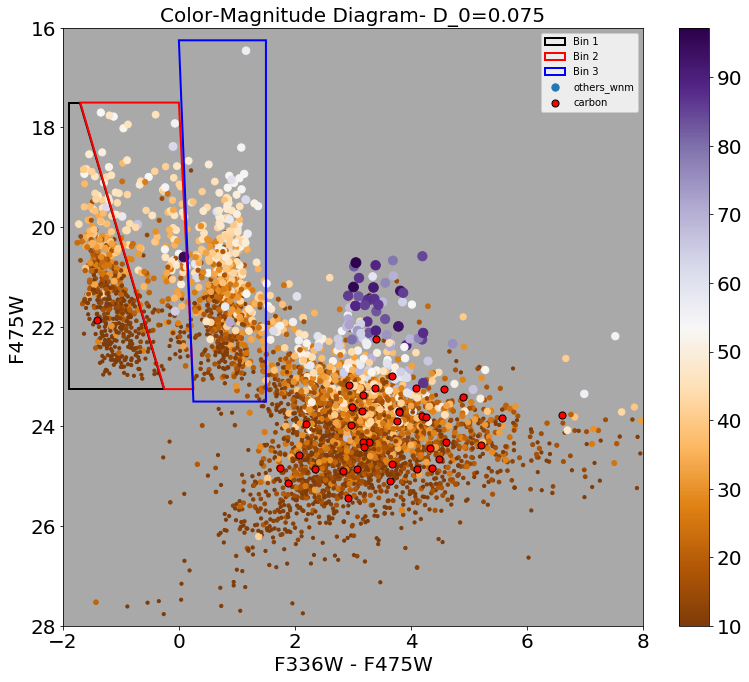

In [58]:
#creates the CMD with our bins
plt.rcParams['figure.figsize'] = 13,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('darkgrey')

# plt.scatter((data.F336W[allcarbon] - data.F475W[allcarbon]), data.F475W[allcarbon], s = 30, color = 'red', label = 'carbon')
plt.scatter((data.F336W[kphothers_wnm] - data.F475W[kphothers_wnm]), data.F475W[kphothers_wnm], c=weight_kphothers_wnm,s = weight_kphothers_wnm, cmap='PuOr', label = 'others_wnm', facecolors = 'none')
plt.colorbar()
plt.scatter((data.F336W[allcarbon] - data.F475W[allcarbon]), data.F475W[allcarbon], s = 50, color = 'red', label = 'carbon',edgecolors='black',linewidths=1)

#plt.plot(xRos, yRos, color = 'black', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

plt.title("Color-Magnitude Diagram- D_0=0.075", size = 20) 
plt.ylabel("F475W", size = 20)
plt.xlabel("F336W - F475W", size = 20)
plt.xlim(-2, 8)
plt.ylim(16, 28)
# plt.xlim(1,4)
# plt.ylim(21,16)

#plots the bins 
polygon(bin1, 'black', 'Bin 1',linewidth=2)  
polygon(bin2,'red','Bin 2',linewidth =2)
polygon(bin3,'blue','Bin 3',linewidth =2)
# polygon(bin4,'green','Bin 4',linewidth =2)
# polygon(bin5,'purple','Bin 5',linewidth =2)
# polygon(bin6,'brown','Bin 6',linewidth =2)

plt.gca().invert_yaxis()
plt.legend(loc = "upper right")

plt.show()

## Coadding F814-160 vs 160

In [59]:
#define list of coordinates for bins

#bottom-right,bottom left, top left, top right
bin4 = [[1.6,23],[.89,23],[1.75,14.5],[2.55,14.5]]
bin5 = [[1.6,23],[2.55,14.5],[5,17]]


bin4_path = path.Path(bin4)
bin5_path = path.Path(bin5)


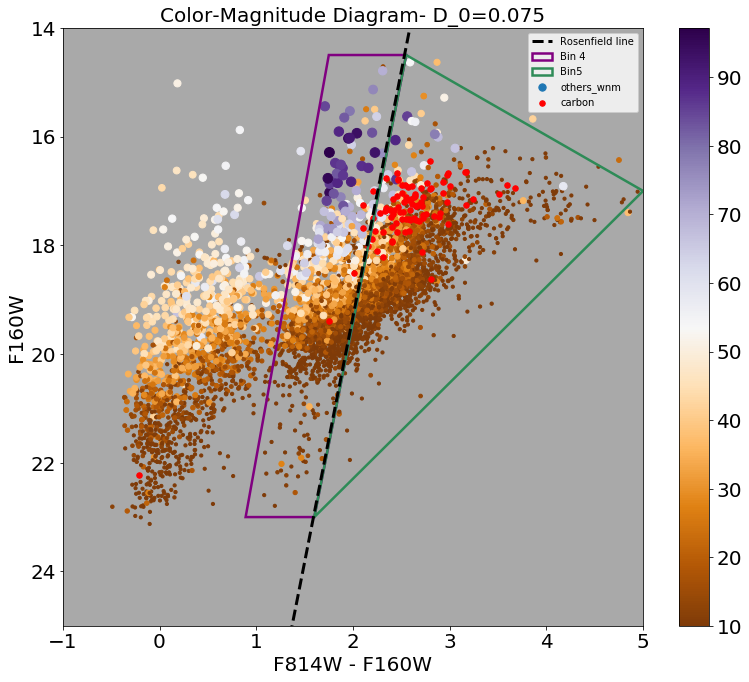

In [60]:
#cmd 814/475
plt.rcParams['figure.figsize'] = 13,11
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('darkgrey')

plt.scatter((data.F814W[kphothers_wnm] - data.F160W[kphothers_wnm]), data.F160W[kphothers_wnm], c=weight_kphothers_wnm,s = weight_kphothers_wnm, cmap='PuOr', label = 'others_wnm', facecolors = 'none')
plt.colorbar()
plt.scatter((data.F814W[allcarbon] - data.F160W[allcarbon]), data.F160W[allcarbon], s = 30, color = 'red', label = 'carbon')

plt.plot(xRos, yRos, color = 'black', linewidth = 3, linestyle = '--', label = 'Rosenfield line')

polygon(bin4,'purple',label='Bin 4')
polygon(bin5,'seagreen',label='Bin5')

plt.title("Color-Magnitude Diagram- D_0=0.075", size = 20) 
plt.ylabel("F160W", size = 20)
plt.xlabel("F814W - F160W", size = 20)
plt.xlim(-1, 5)
plt.ylim(25, 14)
# plt.xlim(1,4)
# plt.ylim(21,16)
plt.legend(loc = "upper right")

plt.show()

In [61]:
#defines functions that determine whether or not a specific point is within a specific polygon
#method: draws a right-travelling ray originating at the test point and determines how many times that ray crosses a polygon edge. If this number is odd, the point is within the polygon
#created by Arya 2018, automation 2.6.1

def pointInPolygon(point, vertices):
    '''
    point: a tuple representing the coordinates of the point to be tested
    vertices: a list of tuples in which each tuple represents a vertex of the polygon to be tested
    Note that the vertices should be in consecutive order (meaning the order that they are connected in the polygon). The starting point does not matter, but the order does
    
    Returns True if the point is within the polygon
    Returns False if the point is outside of the polygon or if the point is on the boundary of the polygon
    '''
    #assumption: no points are on the boundary
    #the right-travelling ray originating at "point" is represented by all points whose x is ≥ p.x, and y = p.y
    #compute edges of polygon, represented by tuples (x1, y1, x2, y2)
    segments = []
    for i in range(len(vertices)):
        p1 = vertices[i]
        if(i == len(vertices) - 1):
            p2 = vertices[0]
        else:
            p2 = vertices[i + 1]
        segments.append((p1[0], p1[1], p2[0], p2[1]))
    crossCount = 0
    for seg in segments:
        if raySegmentIntersection(point, seg):
            crossCount += 1
    return (crossCount % 2 == 1)

#defines a helper function used in the above function
#this function tests to see if two rays intersect
def raySegmentIntersection(rayVertex, segment):
    '''
    rayVertex: a tuple representing the endpoint of the ray (in this case, it will be originating at the point to be tested)
    segment: a tuple representing the endpoints of the line segment being tested, in the form (x1, y1, x2, y2)
    
    Returns True if a right-pointing ray originating at rayVertex intersects segment
    Returns False if the opposite is true and the ray does not intersect the segment
    '''
    x1, y1, x2, y2 = segment[0], segment[1], segment[2], segment[3]
    px, py = rayVertex[0], rayVertex[1]
    
    #checks to see if it is even possible that these rays intersect: 
    #segment's ys must be on opposite sides of the ray, and at least one of the x's must be to the right of the point.
    if((y1 - py) * (y2 - py) < 0 and (x2 > px or x1 > px)):
        slopey = (segment[3]-segment[1])
        slopex = (segment[2]-segment[0])
        if slopey == 0: #the segment is a horizontal line
            return False #in this version, anything on boundary is not considered within the polygon, so say this doesn't intersect, to keep intersection values at 0 (such that 0 % 2 == 1 is False)
            
        #formula created to figure out whether point is inside (after algebraic manipulation): ((py-y1)(x2-x1)/(y2-y1)) + x1 > px
        return ((py-y1) * slopex / slopey) + x1 > px

In [62]:
#combined indices of all stars to have authentic machine classification
kphothers_wnm_carbon = np.concatenate((keckPhotoOthers,wNm),axis=None)
kphothers_wnm_carbon = np.concatenate((kphothers_wnm_carbon,allcarbon),axis=None)


### set threshold

In [63]:
#creates dictionaries of stars and their coordinates on the CMD created by the graphCMD function
#keys are star indices and values are tuples containing the coordinates
kphothers_wnm_coords336, carbon_coords336 = {}, {}
for star,value in weight_kphothers_wnm_dict.items():
    if value > 65:
        coordinates = (data["F336W"][star] - data["F475W"][star], data["F475W"][star])
        kphothers_wnm_coords336[star] = coordinates

kphothers_wnm_coords814, carbon_coords814 = {}, {}
for star,value in weight_kphothers_wnm_dict.items():
    if value > 65:
        coordinates = (data["F814W"][star] - data["F160W"][star], data["F160W"][star])
        kphothers_wnm_coords814[star] = coordinates

        # for star in kphothers_wnm_carbon:
#     coordinates = (carbon_score2_uwdict[star].items(),carbon_score2_ucdict[star].items())
#     carbon_coords[star] = coordinates

In [64]:
len(kphothers_wnm_coords336)

64

In [65]:
#creates lists of kphothers/weak CN star indices that fall within each of the coaddition bins created on the CMD above
kphothers_wnm_bin1, kphothers_wnm_bin2,kphothers_wnm_bin3 =[],[],[]
kphothers_wnm_bin4,kphothers_wnm_bin5 =[],[]
carbon_bin =[]


#CMD 814/160 has bins 4,5,6
for star in kphothers_wnm_coords814:    
    if pointInPolygon(kphothers_wnm_coords814[star], bin4):
        kphothers_wnm_bin4.append(star)
        
    if pointInPolygon(kphothers_wnm_coords814[star], bin5):
        kphothers_wnm_bin5.append(star)
        
#CMD 336/475 has bins 1,2,3
stars_incoord = []

for star in kphothers_wnm_coords336:
    if star not in kphothers_wnm_bin4:
        stars_incoord.append(star)
        
for star in stars_incoord:     
    if pointInPolygon(kphothers_wnm_coords336[star], bin1):
        kphothers_wnm_bin1.append(star)

    if pointInPolygon(kphothers_wnm_coords336[star], bin2):
        kphothers_wnm_bin2.append(star)

    if pointInPolygon(kphothers_wnm_coords336[star], bin3):
        kphothers_wnm_bin3.append(star)



In [66]:
stars_incoord_65 = [20119,20786,21090,21321,21475,21500,21734,23079,21565,23439,24395,22982]

In [67]:
print('Threshold W > 65')
print('bin1 =',len(kphothers_wnm_bin1))
print('bin2 =',len(kphothers_wnm_bin2))
print('bin3 =',len(kphothers_wnm_bin3))
print('bin4 =',len(kphothers_wnm_bin4))
print('bin5 =',len(kphothers_wnm_bin5))

#print(len(carbon_bin))



Threshold W > 65
bin1 = 0
bin2 = 1
bin3 = 0
bin4 = 53
bin5 = 9


In [68]:
#combining bins - was tested 

#bin 1,2,3 from CMD 336/475
kphothers_wnm_bin123 = np.concatenate((kphothers_wnm_bin1,kphothers_wnm_bin2),axis=None)
kphothers_wnm_bin123 = np.concatenate((kphothers_wnm_bin123,kphothers_wnm_bin3),axis=None)

# #bins 4,5,6 from CMD 814/160
# kphothers_wnm_bin456 =  np.concatenate((kphothers_wnm_bin4,kphothers_wnm_bin5),axis=None)
# kphothers_wnm_bin456 =  np.concatenate((kphothers_wnm_bin456,kphothers_wnm_bin6),axis=None)


In [69]:
#creates coadditions of the binned samples outlined in the CMD in the section above

#khpothers and weak CN coadditions
kphothers_wnm_wv_123, kphothers_wnm_flux_123, kphothers_wnm_ivar_123 = getTempSpec(kphothers_wnm_bin123)
kphothers_wnm_wv_4, kphothers_wnm_flux_4, kphothers_wnm_ivar_4 = getTempSpec(kphothers_wnm_bin4)
kphothers_wnm_wv_5, kphothers_wnm_flux_5, kphothers_wnm_ivar_5 = getTempSpec(kphothers_wnm_bin5)

#if it throws an error is it because there needs to be more than 1 star in each bin

Step 1 of 3 complete. Normalized spectra and inverse variances loaded.


IndexError: list index out of range

In [70]:
#graphs the carbon and weak CN coadditions on the same plot
x123 = kphothers_wnm_wv_123
x4, x5 = kphothers_wnm_wv_4,kphothers_wnm_wv_5
y123 = kphothers_wnm_flux_123
y4, y5 = kphothers_wnm_flux_4,kphothers_wnm_flux_5

x,y =Wtemplate_wv,Wtemplate

fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')

plt.rcParams['figure.figsize'] = 30,11
# plt.plot(x1, y1 + 0.3, color = 'black', label = 'Bin 1')
# plt.plot(x2, y2 + 0.15, color = 'red', label = 'Bin 2')
plt.plot(x123, y123, color = 'blue',label = 'Bin 123')
plt.plot(x4, y4 - 0.25, color = 'green', label = 'Bin 4')
plt.plot(x5, y5 - .5, color = 'purple', label = 'Bin 5')
plt.plot(x ,y - 1, label ='Weak CN Template')

plt.title("Coadded Spectra of Stars - D_0 = 0.075/Threshold Weight >65", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 25)
plt.xlabel("Wavelength", size = 25)
plt.ylim(-0.2, 1.2)
plt.xlim(7800, 8200)
plt.legend(fontsize = 20,loc='upper right')
plt.show()

NameError: name 'kphothers_wnm_wv_123' is not defined

In [ ]:
#graphs the limited-range weak CN template spectrum 
fig = plt.figure()
fig.patch.set_facecolor('white')
ax = plt.axes()
ax.patch.set_facecolor('white')


x = Wtemplate_wv.tolist()
y = Wtemplate.tolist()
plt.rcParams['figure.figsize'] = 30,11
plt.plot(x, y)
plt.title("Coadded Weak CN Template Spectrum", size = 30)
plt.ylabel("Flux (normalized & weighted with ivar)", size = 20)
plt.xlabel("Wavelength", size = 20)
plt.show()